# Прогнозирование временных рядов.

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd

# Импорт matplotlib
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

#### Данные о пассажирских авиаперевозках:
Международные пассажирские авиаперевозки в тысячах человек за каждый месяц с января 1949 по декабрь 1960 года.

In [2]:
ser_g = pd.read_csv('series_g.csv', sep=';')
ser_g.head()

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121


In [3]:
# Преобразуем строчки с датами в объект datetime
# format='%b %Y' означает, что в нашей строчке сначала идёт трёхбуквенное название месяца (%b), а затем год (%Y)
ser_g['date'] = pd.to_datetime(ser_g['date'], format='%b %Y')
#  Добавляем столбоц с логарифмом от объема пассажироперевозок
ser_g['log_y'] = np.log10(ser_g['series_g'])

In [4]:
#  Смотрим, что получилось
ser_g.head()

,date,series_g,log_y
0,1949-01-01,112,2.049218
1,1949-02-01,118,2.071882
2,1949-03-01,132,2.120574
3,1949-04-01,129,2.110590
4,1949-05-01,121,2.082785


Построим графики объёма пассажироперевозок и проверим, какой тип тренда (линейный или нет) и какой тип сезонности ( аддитивный или мультипликативный), наблюдается. По первому графику уже прослеживается линейный тренд и мультипликативная сезонность. Но чтобы окончательно убедиться в последнем, добавим график логарифма от этой же величины. После логирафмирования циклы стали одинаковой высоты, а это и говорит о мультипликативном харакрете сезонности.

Text(0, 0.5, 'log10 от тысяч человек')

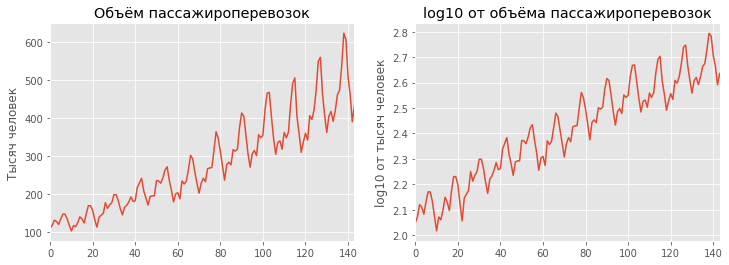

In [5]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121)
ser_g['series_g'].plot(ax=ax1)
ax1.set_title(u'Объём пассажироперевозок')
ax1.set_ylabel(u'Тысяч человек')

ax2 = fig.add_subplot(122)
pd.Series(ser_g['log_y']).plot(ax=ax2)
ax2.set_title(u'log10 от объёма пассажироперевозок')
ax2.set_ylabel(u'log10 от тысяч человек')


## Прогнозирование с использованием линейной регрессии

Будем строить модель линейной регрессии для приближения логарифма от объёма перевозок. То есть
$$\log y_i = \beta x_i + c(x_i) + \varepsilon_i,$$
где $y_i$ -- объём перевозок, $x_i$ -- порядковый номер месяца, $c(x_i)$ -- сезонная составляющая, $\varepsilon_i$ -- случайный шум.

Для удобства дальнейшего использования создадим дополнительно 12 новых месяцев для построения прогноза на них. Для этого создадим эти 12 новых дат с помощью функции ```pd.date_range```. Данный объект будет объектом класса ```DateTimeIndex``` (наследованный от класса ```Index```), и чтобы объединить их с колонкой ```ser_g['date']```, принадлежащей классу ```datetime64```, придётся привести последнюю к классу ```Index```. Объединим два набора дат и сохраним их в объекте ```new_dates```.

Далее создадим фиктивный датафрейм ```df2```, состоящий из одной колонки с этими новыми датами, и приклеим его к исходному датафрейму ```ser_g``` с помозью функции ```pd.merge```, создав при этом датафрейм ```df```. Эта функция склеивает два датасета по указанному набору колонок (параметр ```on```) и по указанному правилу склейки (параметр ```how```). В ```on``` указываем одну общую колонку ```date```, по которой нужно произвести склейку. В ```how``` указываем ```right```, что означает следующее: 
возьми весь правый датасет и приклей к нему левый датасет по условию совпадения значений колонки ```on```, а в случае если для значений из правой колонки ```on``` не найдётся соотвествующих значений в левой колонке ```on```, то тогда приклей ```NaN``` значения. Вообще говоря, опция ```how``` соответствует опциям ```JOIN``` в языке SQL (```LEFT JOIN```, ```RIGHT_JOIN```, ```INNER JOIN```, ```OUTER_JOIN```).

In [6]:
# Создаём последовательсть месяцев. freq='MS' означает первое число каждого месяца из указанного диапазона дат
new_dates = pd.date_range('1961-01-01', '1961-12-01', freq='MS')

# Приводим ser_g['date'] к типу Index, объединяем с 12 месяцами, полученными на предыдущем шаге
new_dates = pd.Index(ser_g['date']) | new_dates

# Создаём датафрейм из одной колонки с расширенным набором дат
df2 = pd.DataFrame({'date': new_dates})

# Объединяем два датафрейма по колонке 'date' в датафрейм df.
# опция how соответствует опциям JOIN в SQL
df = pd.merge(ser_g, df2, on='date', how='right')

Создадим регрессионную переменную ```month_num``` -- порядковый номер пары (месяц, год). И прологарифмируем таргет.

In [7]:
df['month_num'] = range(1, len(df) + 1)
df['log_y'] = np.log10(df['series_g'])

Создадим 12 колонок ```season_1```, ```season_2```, ..., ```season_12```, в которые поместим индикаторы соответствующего месяца. Чтобы достать порядковый номер месяца в каждой строчке, применим последовательно пару методов ```dt``` и ```month``` к колонке ```df['date']```. Внутри цикла будем проверять, равен ли очередной месяц текущему значению из цикла.

In [8]:
for x in range(1, 13):
    df['season_' + str(x)] = df['date'].dt.month == x

Правда, для устранения линейной зависимости между колонками, один из сезонных индикаторов придётся исключить. Пусть базовым месяцем будет январь.

In [9]:
# xrange(2, 13) соответствует всем месяцам с февраля по декабрь
season_columns = ['season_' + str(x) for x in range(2, 13)]

# Создадим объекты матрицу X и вектор y для обучения модели
X = df[['month_num'] + season_columns]
y = df['log_y']

# Оставим только те строчки, у которых известны значения y (с номерами от 60 до 144).
# Первые 60 наблюдений отбрасываем, потому, что они испортят прогноз.
X1 = X[60:144]
y1 = y[60:144]

Настраиваем линейную регрессионную модель.

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
model = LinearRegression()
model.fit(X1, y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Считаем качество модели (коэффициент $R^2$).

In [12]:
print ('R^2: {0}'.format(model.score(X1, y1)))

R^2: 0.9748793547553932


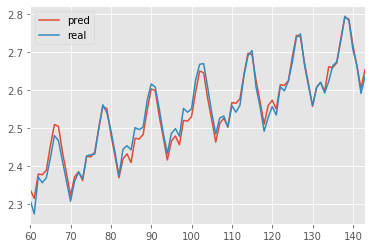

In [13]:
pred = pd.DataFrame({
    'pred': model.predict(X1),
    'real': y1})
pred.plot()

Теперь построим предсказание для всей матрицы ```X```, включая неизвестные добавленных 12 месяцев.

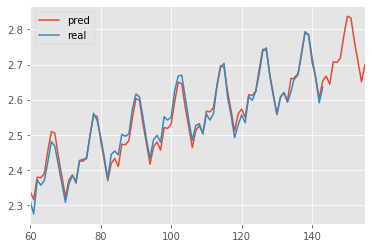

In [14]:
pred = pd.DataFrame({
    'pred': model.predict(X[60:]),
    'real': y[60:]})
pred.plot()

Выведем предсказанные значения на 12 месяцев вперед (тыс.чел. в месяц)

In [15]:
10**model.predict(X[144:])

array([464.32718369, 440.26033056, 510.22193527, 507.93449309,
       522.24325509, 605.27326499, 687.95961997, 680.97578391,
       582.42250084, 512.32243127, 447.48144967, 501.39937568])

## Прогнозирование с использованием нейронной сети

In [16]:
# Смотрим на данные
ser_g.head()

,date,series_g,log_y
0,1949-01-01,112,2.049218
1,1949-02-01,118,2.071882
2,1949-03-01,132,2.120574
3,1949-04-01,129,2.110590
4,1949-05-01,121,2.082785


In [17]:
# Преобразуем данные

# Создаем таблицу таким образом, что бы каждая строка сообветствовала периоду (1 год):
# в строке 13 (12+1) значений, соответствующих показателю за каждый месяц,
# значение за 13 месяц будет как-бы предсказанием по предыдущим 12 (вектор Y, для обучающей и тестовой выборки)

ser_g_2 = pd.DataFrame()

for i in range(12,0,-1):
    ser_g_2['t-'+str(i)] = ser_g.iloc[:,2].shift(i)

ser_g_2['t'] = ser_g.iloc[:,2].values

print(ser_g_2.head(13))

        t-12      t-11      t-10       t-9       t-8       t-7       t-6  \
0        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6        NaN       NaN       NaN       NaN       NaN       NaN  2.049218   
7        NaN       NaN       NaN       NaN       NaN  2.049218  2.071882   
8        NaN       NaN       NaN       NaN  2.049218  2.071882  2.120574   
9        NaN       NaN       NaN  2.049218  2.071882  2.120574  2.110590   
10       NaN       NaN  2.049218  2.071882  2.120574  2.110590  2.082785   
11       NaN  2.049218  2.071882  2.120574  2.110590  2.082785  2.130334   
12  2.049218

In [18]:
#  Отрезаем первые 12 строк (строки с NaN)
ser_g_4 = ser_g_2[12:]
#  Проверяем, что все в порядке
ser_g_4.head()

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
12,2.049218,2.071882,2.120574,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698
13,2.071882,2.120574,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371
14,2.120574,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371,2.149219
15,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371,2.149219,2.130334
16,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371,2.149219,2.130334,2.096910


In [19]:
print(ser_g_4.shape)

(132, 13)


In [20]:
#  предикторы и отклик разделяем
# Отклик  вектор y
y = ser_g_4['t']
# Предикторы - таблица X
X = ser_g_4.drop('t', axis=1)

In [21]:
# Разделяем на обучающую и тестовую выборки
# В обучающую первые 60 значений не включаем, что бы не испортить прогноз
# Тестовая - последние наблюдения
X_train = X[60:120]
y_train = y[60:120]
X_test  = X[120:]
y_test  = y[120:]

In [22]:
#  Все хорошо?
print(ser_g_4.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(132, 13)
(60, 12)
(60,)
(12, 12)
(12,)


In [23]:
#  Преобразование pandas dataframe в numpy array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [24]:
# Подключаем библиотеки для создания нейронной сети
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomNormal, RandomUniform
from tensorflow.keras import optimizers

In [25]:
# Создание модели
model = Sequential()
model.add(Dense(6, input_dim=12, activation='relu'))
model.add(Dense(1, activation='linear'))

# Компиляция
#sgd = SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
#adanm = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [26]:
# Обучение нейронной сети

model.fit(X_train, y_train, epochs=10000)

Train on 60 samples
Epoch 1/10000
60/60 [==============================] - 0s 7ms/sample - loss: 4.1237 - mean_absolute_percentage_error: 79.7837
Epoch 2/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7188 - mean_absolute_percentage_error: 75.7590
Epoch 3/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.3361 - mean_absolute_percentage_error: 71.7504
Epoch 4/10000
60/60 [==============================] - 0s 183us/sample - loss: 2.9764 - mean_absolute_percentage_error: 67.7731
Epoch 5/10000
60/60 [==============================] - 0s 116us/sample - loss: 2.6419 - mean_absolute_percentage_error: 63.8369
Epoch 6/10000
60/60 [==============================] - 0s 150us/sample - loss: 2.3304 - mean_absolute_percentage_error: 59.9463
Epoch 7/10000
60/60 [==============================] - 0s 166us/sample - loss: 2.0425 - mean_absolute_percentage_error: 56.1274
Epoch 8/10000
60/60 [==============================] - 0s 232us/sample - loss: 1.7791 

60/60 [==============================] - 0s 100us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6476
Epoch 65/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6469
Epoch 66/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6473
Epoch 67/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6473
Epoch 68/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6477
Epoch 69/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6483
Epoch 70/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6492
Epoch 71/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0033 - mean_absolute_percentage_error

60/60 [==============================] - 0s 100us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6645
Epoch 128/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6645
Epoch 129/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6652
Epoch 130/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6656
Epoch 131/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6657
Epoch 132/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6656
Epoch 133/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0033 - mean_absolute_percentage_error: 1.6660
Epoch 134/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0033 - mean_absolute_percentag

60/60 [==============================] - 0s 100us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6631
Epoch 191/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6635
Epoch 192/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6638
Epoch 193/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6628
Epoch 194/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6621
Epoch 195/10000
60/60 [==============================] - 0s 249us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6610
Epoch 196/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6606
Epoch 197/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0032 - mean_absolute_percentag

60/60 [==============================] - 0s 133us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6528
Epoch 254/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6537
Epoch 255/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6542
Epoch 256/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6547
Epoch 257/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6550
Epoch 258/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6554
Epoch 259/10000
60/60 [==============================] - 0s 216us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6526
Epoch 260/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0032 - mean_absolute_percentag

60/60 [==============================] - 0s 116us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6503
Epoch 317/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6496
Epoch 318/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6486
Epoch 319/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6496
Epoch 320/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6495
Epoch 321/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6484
Epoch 322/10000
60/60 [==============================] - 0s 149us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6487
Epoch 323/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0032 - mean_absolute_percentag

60/60 [==============================] - 0s 116us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6403
Epoch 380/10000
60/60 [==============================] - 0s 199us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6389
Epoch 381/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6380
Epoch 382/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6369
Epoch 383/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6357
Epoch 384/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6353
Epoch 385/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6362
Epoch 386/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0032 - mean_absolute_percentag

60/60 [==============================] - 0s 116us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6330
Epoch 443/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6322
Epoch 444/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6326
Epoch 445/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6331
Epoch 446/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6335
Epoch 447/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6327
Epoch 448/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0032 - mean_absolute_percentage_error: 1.6338
Epoch 449/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0032 - mean_absolute_percentag

60/60 [==============================] - 0s 166us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6244
Epoch 505/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6221
Epoch 506/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6255
Epoch 507/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6257
Epoch 508/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6266
Epoch 509/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6252
Epoch 510/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6233
Epoch 511/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0031 - mean_absolute_percentag

60/60 [==============================] - 0s 183us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6180
Epoch 568/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6185
Epoch 569/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6191
Epoch 570/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6200
Epoch 571/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6215
Epoch 572/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6216
Epoch 573/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6216
Epoch 574/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0031 - mean_absolute_percentag

60/60 [==============================] - 0s 133us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6075
Epoch 631/10000
60/60 [==============================] - 0s 216us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6070
Epoch 632/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6081
Epoch 633/10000
60/60 [==============================] - 0s 149us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6033
Epoch 634/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6052
Epoch 635/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6069
Epoch 636/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0031 - mean_absolute_percentage_error: 1.6125
Epoch 637/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0031 - mean_absolute_percentag

60/60 [==============================] - 0s 150us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5938
Epoch 694/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5958
Epoch 695/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5968
Epoch 696/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5966
Epoch 697/10000
60/60 [==============================] - 0s 83us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5960
Epoch 698/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5964
Epoch 699/10000
60/60 [==============================] - 0s 199us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5960
Epoch 700/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0030 - mean_absolute_percentage

60/60 [==============================] - 0s 99us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5817
Epoch 757/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5833
Epoch 758/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5821
Epoch 759/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5805
Epoch 760/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5812
Epoch 761/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5820
Epoch 762/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5790
Epoch 763/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0030 - mean_absolute_percentage

60/60 [==============================] - 0s 116us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5793
Epoch 820/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5761
Epoch 821/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5740
Epoch 822/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5731
Epoch 823/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5688
Epoch 824/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5689
Epoch 825/10000
60/60 [==============================] - 0s 99us/sample - loss: 0.0030 - mean_absolute_percentage_error: 1.5695
Epoch 826/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0030 - mean_absolute_percentage

60/60 [==============================] - 0s 116us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5594
Epoch 883/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5586
Epoch 884/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5579
Epoch 885/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5614
Epoch 886/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5619
Epoch 887/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5634
Epoch 888/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5629
Epoch 889/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0029 - mean_absolute_percentag

60/60 [==============================] - 0s 116us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5499
Epoch 946/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5529
Epoch 947/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5518
Epoch 948/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5470
Epoch 949/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5454
Epoch 950/10000
60/60 [==============================] - 0s 117us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5444
Epoch 951/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5441
Epoch 952/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0029 - mean_absolute_percentag

60/60 [==============================] - 0s 150us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5339
Epoch 1009/10000
60/60 [==============================] - 0s 199us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5331
Epoch 1010/10000
60/60 [==============================] - 0s 266us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5314
Epoch 1011/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5294
Epoch 1012/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0029 - mean_absolute_percentage_error: 1.5408
Epoch 1013/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5367
Epoch 1014/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5339
Epoch 1015/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0028 - mean_absolute_pe

60/60 [==============================] - 0s 133us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5134
Epoch 1072/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5149
Epoch 1073/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5243
Epoch 1074/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5256
Epoch 1075/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5234
Epoch 1076/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5230
Epoch 1077/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0028 - mean_absolute_percentage_error: 1.5217
Epoch 1078/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0028 - mean_absolute_pe

60/60 [==============================] - 0s 166us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.5134
Epoch 1135/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.5099
Epoch 1136/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.5040
Epoch 1137/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.5019
Epoch 1138/10000
60/60 [==============================] - 0s 199us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.4991
Epoch 1139/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.4978
Epoch 1140/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.4983
Epoch 1141/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0027 - mean_absolute_pe

60/60 [==============================] - 0s 100us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.4856
Epoch 1198/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.4835
Epoch 1199/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.4847
Epoch 1200/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.4844
Epoch 1201/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.4846
Epoch 1202/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.4853
Epoch 1203/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0027 - mean_absolute_percentage_error: 1.4931
Epoch 1204/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0027 - mean_absolute_pe

60/60 [==============================] - 0s 200us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4713
Epoch 1261/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4699
Epoch 1262/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4676
Epoch 1263/10000
60/60 [==============================] - 0s 167us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4653
Epoch 1264/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4629
Epoch 1265/10000
60/60 [==============================] - 0s 167us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4619
Epoch 1266/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4621
Epoch 1267/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0026 - mean_absolute_pe

60/60 [==============================] - 0s 166us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4519
Epoch 1323/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4517
Epoch 1324/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4516
Epoch 1325/10000
60/60 [==============================] - 0s 149us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4523
Epoch 1326/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4490
Epoch 1327/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4546
Epoch 1328/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0026 - mean_absolute_percentage_error: 1.4543
Epoch 1329/10000
60/60 [==============================] - ETA: 0s - loss: 0.0029 - mean_absolute_percentage

60/60 [==============================] - 0s 199us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4343
Epoch 1385/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4258
Epoch 1386/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4297
Epoch 1387/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4290
Epoch 1388/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4311
Epoch 1389/10000
60/60 [==============================] - 0s 216us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4359
Epoch 1390/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4335
Epoch 1391/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0025 - mean_absolute_pe

60/60 [==============================] - 0s 100us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4265
Epoch 1448/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4234
Epoch 1449/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4236
Epoch 1450/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4165
Epoch 1451/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4125
Epoch 1452/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4053
Epoch 1453/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0025 - mean_absolute_percentage_error: 1.4047
Epoch 1454/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0025 - mean_absolute_pe

60/60 [==============================] - 0s 150us/sample - loss: 0.0024 - mean_absolute_percentage_error: 1.3899
Epoch 1511/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0024 - mean_absolute_percentage_error: 1.3907
Epoch 1512/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0024 - mean_absolute_percentage_error: 1.3918
Epoch 1513/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0024 - mean_absolute_percentage_error: 1.3895
Epoch 1514/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0024 - mean_absolute_percentage_error: 1.3901
Epoch 1515/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0024 - mean_absolute_percentage_error: 1.3906
Epoch 1516/10000
60/60 [==============================] - 0s 117us/sample - loss: 0.0024 - mean_absolute_percentage_error: 1.3900
Epoch 1517/10000
60/60 [==============================] - 0s 83us/sample - loss: 0.0024 - mean_absolute_per

60/60 [==============================] - 0s 133us/sample - loss: 0.0024 - mean_absolute_percentage_error: 1.3770
Epoch 1573/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0024 - mean_absolute_percentage_error: 1.3764
Epoch 1574/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0024 - mean_absolute_percentage_error: 1.3759
Epoch 1575/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0023 - mean_absolute_percentage_error: 1.3747
Epoch 1576/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0024 - mean_absolute_percentage_error: 1.3762
Epoch 1577/10000
60/60 [==============================] - 0s 117us/sample - loss: 0.0023 - mean_absolute_percentage_error: 1.3771
Epoch 1578/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0023 - mean_absolute_percentage_error: 1.3742
Epoch 1579/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0023 - mean_absolute_pe

60/60 [==============================] - 0s 100us/sample - loss: 0.0023 - mean_absolute_percentage_error: 1.3518
Epoch 1635/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0023 - mean_absolute_percentage_error: 1.3556
Epoch 1636/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0023 - mean_absolute_percentage_error: 1.3556
Epoch 1637/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0023 - mean_absolute_percentage_error: 1.3676
Epoch 1638/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0023 - mean_absolute_percentage_error: 1.3713
Epoch 1639/10000
60/60 [==============================] - 0s 83us/sample - loss: 0.0023 - mean_absolute_percentage_error: 1.3641
Epoch 1640/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0023 - mean_absolute_percentage_error: 1.3526
Epoch 1641/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0023 - mean_absolute_per

60/60 [==============================] - 0s 183us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3410
Epoch 1697/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3366
Epoch 1698/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3312
Epoch 1699/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3337
Epoch 1700/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3313
Epoch 1701/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3297
Epoch 1702/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3306
Epoch 1703/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0022 - mean_absolute_pe

60/60 [==============================] - 0s 166us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3182
Epoch 1760/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3172
Epoch 1761/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3185
Epoch 1762/10000
60/60 [==============================] - 0s 83us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3156
Epoch 1763/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3148
Epoch 1764/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3076
Epoch 1765/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0022 - mean_absolute_percentage_error: 1.3127
Epoch 1766/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0022 - mean_absolute_per

60/60 [==============================] - 0s 116us/sample - loss: 0.0021 - mean_absolute_percentage_error: 1.2963
Epoch 1822/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0021 - mean_absolute_percentage_error: 1.2931
Epoch 1823/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0021 - mean_absolute_percentage_error: 1.2945
Epoch 1824/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0021 - mean_absolute_percentage_error: 1.2980
Epoch 1825/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0021 - mean_absolute_percentage_error: 1.2971
Epoch 1826/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0021 - mean_absolute_percentage_error: 1.2983
Epoch 1827/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0021 - mean_absolute_percentage_error: 1.3002
Epoch 1828/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0021 - mean_absolute_pe

60/60 [==============================] - 0s 116us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2830
Epoch 1884/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2866
Epoch 1885/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2864
Epoch 1886/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2793
Epoch 1887/10000
60/60 [==============================] - 0s 83us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2749
Epoch 1888/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2766
Epoch 1889/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2790
Epoch 1890/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0020 - mean_absolute_per

60/60 [==============================] - 0s 133us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2585
Epoch 1946/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2629
Epoch 1947/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2606
Epoch 1948/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2605
Epoch 1949/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2586
Epoch 1950/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2563
Epoch 1951/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0020 - mean_absolute_percentage_error: 1.2557
Epoch 1952/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0020 - mean_absolute_pe

60/60 [==============================] - 0s 133us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2408
Epoch 2009/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2393
Epoch 2010/10000
60/60 [==============================] - 0s 83us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2369
Epoch 2011/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2420
Epoch 2012/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2375
Epoch 2013/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2384
Epoch 2014/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2368
Epoch 2015/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0019 - mean_absolute_per

60/60 [==============================] - 0s 183us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2200
Epoch 2071/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2213
Epoch 2072/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2270
Epoch 2073/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2207
Epoch 2074/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2284
Epoch 2075/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2218
Epoch 2076/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0019 - mean_absolute_percentage_error: 1.2202
Epoch 2077/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0018 - mean_absolute_pe

60/60 [==============================] - 0s 150us/sample - loss: 0.0018 - mean_absolute_percentage_error: 1.2033
Epoch 2134/10000
60/60 [==============================] - 0s 117us/sample - loss: 0.0018 - mean_absolute_percentage_error: 1.2018
Epoch 2135/10000
60/60 [==============================] - 0s 83us/sample - loss: 0.0018 - mean_absolute_percentage_error: 1.2026
Epoch 2136/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0018 - mean_absolute_percentage_error: 1.2029
Epoch 2137/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0018 - mean_absolute_percentage_error: 1.2047
Epoch 2138/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0018 - mean_absolute_percentage_error: 1.1998
Epoch 2139/10000
60/60 [==============================] - 0s 83us/sample - loss: 0.0018 - mean_absolute_percentage_error: 1.2023
Epoch 2140/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0018 - mean_absolute_perc

60/60 [==============================] - 0s 117us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1864
Epoch 2197/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1841
Epoch 2198/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1864
Epoch 2199/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1849
Epoch 2200/10000
60/60 [==============================] - 0s 149us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1837
Epoch 2201/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1814
Epoch 2202/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1817
Epoch 2203/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0017 - mean_absolute_pe

60/60 [==============================] - 0s 166us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1692
Epoch 2260/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1693
Epoch 2261/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1647
Epoch 2262/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1653
Epoch 2263/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1729
Epoch 2264/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1589
Epoch 2265/10000
60/60 [==============================] - ETA: 0s - loss: 0.0019 - mean_absolute_percentage_error: 1.31 - 0s 100us/sample - loss: 0.0017 - mean_absolute_percentage_error: 1.1758
Epoch 2266/10000
60/60 [===================

60/60 [==============================] - 0s 150us/sample - loss: 0.0016 - mean_absolute_percentage_error: 1.1460
Epoch 2322/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0016 - mean_absolute_percentage_error: 1.1458
Epoch 2323/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0016 - mean_absolute_percentage_error: 1.1460
Epoch 2324/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0016 - mean_absolute_percentage_error: 1.1448
Epoch 2325/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0016 - mean_absolute_percentage_error: 1.1413
Epoch 2326/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0016 - mean_absolute_percentage_error: 1.1500
Epoch 2327/10000
60/60 [==============================] - ETA: 0s - loss: 0.0017 - mean_absolute_percentage_error: 1.14 - 0s 116us/sample - loss: 0.0016 - mean_absolute_percentage_error: 1.1441
Epoch 2328/10000
60/60 [===================

60/60 [==============================] - 0s 100us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1280
Epoch 2384/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1286
Epoch 2385/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1290
Epoch 2386/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1326
Epoch 2387/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1303
Epoch 2388/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1270
Epoch 2389/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1257
Epoch 2390/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0015 - mean_absolute_pe

60/60 [==============================] - 0s 116us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1051
Epoch 2447/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1124
Epoch 2448/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1113
Epoch 2449/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1100
Epoch 2450/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1075
Epoch 2451/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1093
Epoch 2452/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0015 - mean_absolute_percentage_error: 1.1051
Epoch 2453/10000
60/60 [==============================] - 0s 167us/sample - loss: 0.0015 - mean_absolute_pe

60/60 [==============================] - 0s 116us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0927
Epoch 2509/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0925
Epoch 2510/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0928
Epoch 2511/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0920
Epoch 2512/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0912
Epoch 2513/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0928
Epoch 2514/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0987
Epoch 2515/10000
60/60 [==============================] - 0s 149us/sample - loss: 0.0014 - mean_absolute_pe

60/60 [==============================] - 0s 100us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0740
Epoch 2572/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0743
Epoch 2573/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0726
Epoch 2574/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0721
Epoch 2575/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0718
Epoch 2576/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0726
Epoch 2577/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0014 - mean_absolute_percentage_error: 1.0813
Epoch 2578/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0014 - mean_absolute_pe

60/60 [==============================] - 0s 183us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0410
Epoch 2635/10000
60/60 [==============================] - 0s 117us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0424
Epoch 2636/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0436
Epoch 2637/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0455
Epoch 2638/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0374
Epoch 2639/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0371
Epoch 2640/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0439
Epoch 2641/10000
60/60 [==============================] - 0s 83us/sample - loss: 0.0013 - mean_absolute_per

60/60 [==============================] - 0s 100us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0253
Epoch 2698/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0381
Epoch 2699/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0463
Epoch 2700/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0319
Epoch 2701/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0232
Epoch 2702/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0359
Epoch 2703/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0013 - mean_absolute_percentage_error: 1.0303
Epoch 2704/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0012 - mean_absolute_pe

60/60 [==============================] - 0s 183us/sample - loss: 0.0012 - mean_absolute_percentage_error: 1.0396
Epoch 2760/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0012 - mean_absolute_percentage_error: 1.0268
Epoch 2761/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0012 - mean_absolute_percentage_error: 1.0122
Epoch 2762/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0012 - mean_absolute_percentage_error: 1.0110
Epoch 2763/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0012 - mean_absolute_percentage_error: 1.0216
Epoch 2764/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0012 - mean_absolute_percentage_error: 1.0098
Epoch 2765/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0012 - mean_absolute_percentage_error: 1.0227
Epoch 2766/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0012 - mean_absolute_pe

60/60 [==============================] - 0s 199us/sample - loss: 0.0012 - mean_absolute_percentage_error: 1.0147
Epoch 2823/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0012 - mean_absolute_percentage_error: 1.0136
Epoch 2824/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0012 - mean_absolute_percentage_error: 0.9994
Epoch 2825/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0012 - mean_absolute_percentage_error: 0.9951
Epoch 2826/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0012 - mean_absolute_percentage_error: 0.9952
Epoch 2827/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0012 - mean_absolute_percentage_error: 1.0046
Epoch 2828/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0012 - mean_absolute_percentage_error: 1.0038
Epoch 2829/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0012 - mean_absolute_pe

60/60 [==============================] - 0s 150us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9951
Epoch 2886/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9915
Epoch 2887/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9866
Epoch 2888/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9940
Epoch 2889/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9866
Epoch 2890/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9845
Epoch 2891/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9840
Epoch 2892/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0011 - mean_absolute_pe

60/60 [==============================] - 0s 133us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9688
Epoch 2949/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9711
Epoch 2950/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9671
Epoch 2951/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9843
Epoch 2952/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9844
Epoch 2953/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9738
Epoch 2954/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0011 - mean_absolute_percentage_error: 0.9749
Epoch 2955/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0011 - mean_absolute_pe

60/60 [==============================] - 0s 116us/sample - loss: 0.0010 - mean_absolute_percentage_error: 0.9597
Epoch 3012/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0010 - mean_absolute_percentage_error: 0.9581
Epoch 3013/10000
60/60 [==============================] - 0s 166us/sample - loss: 0.0010 - mean_absolute_percentage_error: 0.9759
Epoch 3014/10000
60/60 [==============================] - 0s 150us/sample - loss: 0.0010 - mean_absolute_percentage_error: 0.9631
Epoch 3015/10000
60/60 [==============================] - 0s 100us/sample - loss: 0.0010 - mean_absolute_percentage_error: 0.9537
Epoch 3016/10000
60/60 [==============================] - 0s 116us/sample - loss: 0.0010 - mean_absolute_percentage_error: 0.9550
Epoch 3017/10000
60/60 [==============================] - 0s 183us/sample - loss: 0.0010 - mean_absolute_percentage_error: 0.9604
Epoch 3018/10000
60/60 [==============================] - 0s 133us/sample - loss: 0.0010 - mean_absolute_pe

60/60 [==============================] - 0s 116us/sample - loss: 9.9880e-04 - mean_absolute_percentage_error: 0.9455
Epoch 3074/10000
60/60 [==============================] - 0s 149us/sample - loss: 9.8365e-04 - mean_absolute_percentage_error: 0.9430
Epoch 3075/10000
60/60 [==============================] - 0s 116us/sample - loss: 9.8108e-04 - mean_absolute_percentage_error: 0.9534
Epoch 3076/10000
60/60 [==============================] - 0s 150us/sample - loss: 9.9308e-04 - mean_absolute_percentage_error: 0.9642
Epoch 3077/10000
60/60 [==============================] - 0s 150us/sample - loss: 9.8349e-04 - mean_absolute_percentage_error: 0.9537
Epoch 3078/10000
60/60 [==============================] - 0s 133us/sample - loss: 9.8255e-04 - mean_absolute_percentage_error: 0.9438
Epoch 3079/10000
60/60 [==============================] - 0s 116us/sample - loss: 9.8222e-04 - mean_absolute_percentage_error: 0.9420
Epoch 3080/10000
60/60 [==============================] - 0s 233us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 9.4310e-04 - mean_absolute_percentage_error: 0.9370
Epoch 3135/10000
60/60 [==============================] - 0s 183us/sample - loss: 9.4430e-04 - mean_absolute_percentage_error: 0.9317
Epoch 3136/10000
60/60 [==============================] - 0s 100us/sample - loss: 9.4768e-04 - mean_absolute_percentage_error: 0.9315
Epoch 3137/10000
60/60 [==============================] - 0s 116us/sample - loss: 9.3969e-04 - mean_absolute_percentage_error: 0.9307
Epoch 3138/10000
60/60 [==============================] - 0s 133us/sample - loss: 9.6201e-04 - mean_absolute_percentage_error: 0.9491
Epoch 3139/10000
60/60 [==============================] - 0s 116us/sample - loss: 9.5600e-04 - mean_absolute_percentage_error: 0.9537
Epoch 3140/10000
60/60 [==============================] - 0s 100us/sample - loss: 9.5342e-04 - mean_absolute_percentage_error: 0.9409
Epoch 3141/10000
60/60 [==============================] - 0s 150us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 9.2232e-04 - mean_absolute_percentage_error: 0.9365
Epoch 3195/10000
60/60 [==============================] - 0s 150us/sample - loss: 9.2287e-04 - mean_absolute_percentage_error: 0.9381
Epoch 3196/10000
60/60 [==============================] - 0s 100us/sample - loss: 9.3594e-04 - mean_absolute_percentage_error: 0.9263
Epoch 3197/10000
60/60 [==============================] - 0s 100us/sample - loss: 9.1435e-04 - mean_absolute_percentage_error: 0.9233
Epoch 3198/10000
60/60 [==============================] - 0s 166us/sample - loss: 9.0583e-04 - mean_absolute_percentage_error: 0.9192
Epoch 3199/10000
60/60 [==============================] - 0s 116us/sample - loss: 9.2700e-04 - mean_absolute_percentage_error: 0.9350
Epoch 3200/10000
60/60 [==============================] - 0s 166us/sample - loss: 9.0947e-04 - mean_absolute_percentage_error: 0.9305
Epoch 3201/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 166us/sample - loss: 9.0113e-04 - mean_absolute_percentage_error: 0.9243
Epoch 3255/10000
60/60 [==============================] - 0s 150us/sample - loss: 8.7847e-04 - mean_absolute_percentage_error: 0.9151
Epoch 3256/10000
60/60 [==============================] - 0s 100us/sample - loss: 8.9067e-04 - mean_absolute_percentage_error: 0.9211
Epoch 3257/10000
60/60 [==============================] - 0s 100us/sample - loss: 8.7770e-04 - mean_absolute_percentage_error: 0.9097
Epoch 3258/10000
60/60 [==============================] - 0s 116us/sample - loss: 8.8327e-04 - mean_absolute_percentage_error: 0.9179
Epoch 3259/10000
60/60 [==============================] - 0s 116us/sample - loss: 8.8691e-04 - mean_absolute_percentage_error: 0.9173
Epoch 3260/10000
60/60 [==============================] - 0s 100us/sample - loss: 8.8212e-04 - mean_absolute_percentage_error: 0.9082
Epoch 3261/10000
60/60 [==============================] - 0s 166us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 8.4420e-04 - mean_absolute_percentage_error: 0.9013
Epoch 3315/10000
60/60 [==============================] - 0s 166us/sample - loss: 8.4942e-04 - mean_absolute_percentage_error: 0.9045
Epoch 3316/10000
60/60 [==============================] - 0s 100us/sample - loss: 8.4708e-04 - mean_absolute_percentage_error: 0.9019
Epoch 3317/10000
60/60 [==============================] - 0s 150us/sample - loss: 8.4827e-04 - mean_absolute_percentage_error: 0.9019
Epoch 3318/10000
60/60 [==============================] - 0s 117us/sample - loss: 8.4416e-04 - mean_absolute_percentage_error: 0.8974
Epoch 3319/10000
60/60 [==============================] - 0s 133us/sample - loss: 8.8566e-04 - mean_absolute_percentage_error: 0.9181
Epoch 3320/10000
60/60 [==============================] - 0s 116us/sample - loss: 8.9224e-04 - mean_absolute_percentage_error: 0.9255
Epoch 3321/10000
60/60 [==============================] - 0s 117us/sample - los

60/60 [==============================] - 0s 166us/sample - loss: 8.5652e-04 - mean_absolute_percentage_error: 0.9152
Epoch 3376/10000
60/60 [==============================] - 0s 100us/sample - loss: 8.2695e-04 - mean_absolute_percentage_error: 0.8965
Epoch 3377/10000
60/60 [==============================] - 0s 116us/sample - loss: 8.1046e-04 - mean_absolute_percentage_error: 0.8845
Epoch 3378/10000
60/60 [==============================] - 0s 117us/sample - loss: 8.5840e-04 - mean_absolute_percentage_error: 0.9075
Epoch 3379/10000
60/60 [==============================] - ETA: 0s - loss: 8.5910e-04 - mean_absolute_percentage_error: 0.90 - 0s 100us/sample - loss: 8.1566e-04 - mean_absolute_percentage_error: 0.8800
Epoch 3380/10000
60/60 [==============================] - 0s 100us/sample - loss: 8.6831e-04 - mean_absolute_percentage_error: 0.9007
Epoch 3381/10000
60/60 [==============================] - 0s 100us/sample - loss: 8.4136e-04 - mean_absolute_percentage_error: 0.9040
Epoch 3382/

60/60 [==============================] - 0s 166us/sample - loss: 8.0337e-04 - mean_absolute_percentage_error: 0.8911
Epoch 3436/10000
60/60 [==============================] - 0s 100us/sample - loss: 7.9987e-04 - mean_absolute_percentage_error: 0.8898
Epoch 3437/10000
60/60 [==============================] - 0s 166us/sample - loss: 7.9288e-04 - mean_absolute_percentage_error: 0.8789
Epoch 3438/10000
60/60 [==============================] - 0s 116us/sample - loss: 7.9028e-04 - mean_absolute_percentage_error: 0.8782
Epoch 3439/10000
60/60 [==============================] - 0s 116us/sample - loss: 7.9523e-04 - mean_absolute_percentage_error: 0.8803
Epoch 3440/10000
60/60 [==============================] - 0s 100us/sample - loss: 7.9498e-04 - mean_absolute_percentage_error: 0.8760
Epoch 3441/10000
60/60 [==============================] - 0s 166us/sample - loss: 7.9902e-04 - mean_absolute_percentage_error: 0.8823
Epoch 3442/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 7.9894e-04 - mean_absolute_percentage_error: 0.8858
Epoch 3497/10000
60/60 [==============================] - 0s 133us/sample - loss: 7.5936e-04 - mean_absolute_percentage_error: 0.8585
Epoch 3498/10000
60/60 [==============================] - 0s 100us/sample - loss: 8.2641e-04 - mean_absolute_percentage_error: 0.8962
Epoch 3499/10000
60/60 [==============================] - 0s 116us/sample - loss: 7.8366e-04 - mean_absolute_percentage_error: 0.8728
Epoch 3500/10000
60/60 [==============================] - 0s 183us/sample - loss: 7.6210e-04 - mean_absolute_percentage_error: 0.8673
Epoch 3501/10000
60/60 [==============================] - 0s 116us/sample - loss: 7.9638e-04 - mean_absolute_percentage_error: 0.8824
Epoch 3502/10000
60/60 [==============================] - 0s 150us/sample - loss: 7.5995e-04 - mean_absolute_percentage_error: 0.8652
Epoch 3503/10000
60/60 [==============================] - 0s 133us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 7.5774e-04 - mean_absolute_percentage_error: 0.8637
Epoch 3558/10000
60/60 [==============================] - 0s 183us/sample - loss: 7.8544e-04 - mean_absolute_percentage_error: 0.8770
Epoch 3559/10000
60/60 [==============================] - 0s 100us/sample - loss: 7.2657e-04 - mean_absolute_percentage_error: 0.8474
Epoch 3560/10000
60/60 [==============================] - 0s 166us/sample - loss: 7.7865e-04 - mean_absolute_percentage_error: 0.8797
Epoch 3561/10000
60/60 [==============================] - 0s 116us/sample - loss: 7.6852e-04 - mean_absolute_percentage_error: 0.8714
Epoch 3562/10000
60/60 [==============================] - 0s 166us/sample - loss: 7.5681e-04 - mean_absolute_percentage_error: 0.8634
Epoch 3563/10000
60/60 [==============================] - 0s 133us/sample - loss: 8.1639e-04 - mean_absolute_percentage_error: 0.8939
Epoch 3564/10000
60/60 [==============================] - 0s 166us/sample - los

60/60 [==============================] - 0s 166us/sample - loss: 7.4076e-04 - mean_absolute_percentage_error: 0.8577
Epoch 3619/10000
60/60 [==============================] - 0s 133us/sample - loss: 7.5047e-04 - mean_absolute_percentage_error: 0.8648
Epoch 3620/10000
60/60 [==============================] - 0s 116us/sample - loss: 7.4727e-04 - mean_absolute_percentage_error: 0.8624
Epoch 3621/10000
60/60 [==============================] - 0s 166us/sample - loss: 7.3673e-04 - mean_absolute_percentage_error: 0.8602
Epoch 3622/10000
60/60 [==============================] - 0s 133us/sample - loss: 7.2569e-04 - mean_absolute_percentage_error: 0.8493
Epoch 3623/10000
60/60 [==============================] - 0s 117us/sample - loss: 7.4227e-04 - mean_absolute_percentage_error: 0.8714
Epoch 3624/10000
60/60 [==============================] - 0s 150us/sample - loss: 7.2228e-04 - mean_absolute_percentage_error: 0.8461
Epoch 3625/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 183us/sample - loss: 7.0010e-04 - mean_absolute_percentage_error: 0.8383
Epoch 3680/10000
60/60 [==============================] - 0s 150us/sample - loss: 7.3403e-04 - mean_absolute_percentage_error: 0.8658
Epoch 3681/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.9931e-04 - mean_absolute_percentage_error: 0.8351
Epoch 3682/10000
60/60 [==============================] - 0s 150us/sample - loss: 7.1882e-04 - mean_absolute_percentage_error: 0.8493
Epoch 3683/10000
60/60 [==============================] - 0s 266us/sample - loss: 7.1201e-04 - mean_absolute_percentage_error: 0.8404
Epoch 3684/10000
60/60 [==============================] - 0s 116us/sample - loss: 7.0296e-04 - mean_absolute_percentage_error: 0.8351
Epoch 3685/10000
60/60 [==============================] - 0s 183us/sample - loss: 7.6151e-04 - mean_absolute_percentage_error: 0.8705
Epoch 3686/10000
60/60 [==============================] - 0s 183us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 6.9494e-04 - mean_absolute_percentage_error: 0.8393
Epoch 3739/10000
60/60 [==============================] - 0s 183us/sample - loss: 6.8148e-04 - mean_absolute_percentage_error: 0.8307
Epoch 3740/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.8142e-04 - mean_absolute_percentage_error: 0.8302
Epoch 3741/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.7544e-04 - mean_absolute_percentage_error: 0.8236
Epoch 3742/10000
60/60 [==============================] - 0s 183us/sample - loss: 6.8025e-04 - mean_absolute_percentage_error: 0.8242
Epoch 3743/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.7534e-04 - mean_absolute_percentage_error: 0.8244
Epoch 3744/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.7587e-04 - mean_absolute_percentage_error: 0.8265
Epoch 3745/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 6.5880e-04 - mean_absolute_percentage_error: 0.8180
Epoch 3800/10000
60/60 [==============================] - 0s 150us/sample - loss: 6.7365e-04 - mean_absolute_percentage_error: 0.8289
Epoch 3801/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.6513e-04 - mean_absolute_percentage_error: 0.8181
Epoch 3802/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.6531e-04 - mean_absolute_percentage_error: 0.8203
Epoch 3803/10000
60/60 [==============================] - 0s 150us/sample - loss: 6.6587e-04 - mean_absolute_percentage_error: 0.8211
Epoch 3804/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.9181e-04 - mean_absolute_percentage_error: 0.8396
Epoch 3805/10000
60/60 [==============================] - 0s 166us/sample - loss: 6.6202e-04 - mean_absolute_percentage_error: 0.8162
Epoch 3806/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 6.5021e-04 - mean_absolute_percentage_error: 0.8182
Epoch 3860/10000
60/60 [==============================] - 0s 183us/sample - loss: 6.5236e-04 - mean_absolute_percentage_error: 0.8207
Epoch 3861/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.4523e-04 - mean_absolute_percentage_error: 0.8112
Epoch 3862/10000
60/60 [==============================] - 0s 133us/sample - loss: 6.4430e-04 - mean_absolute_percentage_error: 0.8087
Epoch 3863/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.4542e-04 - mean_absolute_percentage_error: 0.8103
Epoch 3864/10000
60/60 [==============================] - 0s 133us/sample - loss: 6.4243e-04 - mean_absolute_percentage_error: 0.8079
Epoch 3865/10000
60/60 [==============================] - 0s 117us/sample - loss: 6.5624e-04 - mean_absolute_percentage_error: 0.8174
Epoch 3866/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 6.6296e-04 - mean_absolute_percentage_error: 0.8175
Epoch 3921/10000
60/60 [==============================] - 0s 117us/sample - loss: 6.5591e-04 - mean_absolute_percentage_error: 0.8335
Epoch 3922/10000
60/60 [==============================] - 0s 133us/sample - loss: 6.5646e-04 - mean_absolute_percentage_error: 0.8213
Epoch 3923/10000
60/60 [==============================] - 0s 100us/sample - loss: 6.2423e-04 - mean_absolute_percentage_error: 0.7969
Epoch 3924/10000
60/60 [==============================] - 0s 133us/sample - loss: 6.3686e-04 - mean_absolute_percentage_error: 0.8028
Epoch 3925/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.2399e-04 - mean_absolute_percentage_error: 0.7965
Epoch 3926/10000
60/60 [==============================] - 0s 183us/sample - loss: 6.2734e-04 - mean_absolute_percentage_error: 0.8002
Epoch 3927/10000
60/60 [==============================] - 0s 133us/sample - los

60/60 [==============================] - 0s 150us/sample - loss: 6.0614e-04 - mean_absolute_percentage_error: 0.7871
Epoch 3982/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.5532e-04 - mean_absolute_percentage_error: 0.8051
Epoch 3983/10000
60/60 [==============================] - 0s 166us/sample - loss: 6.1332e-04 - mean_absolute_percentage_error: 0.7838
Epoch 3984/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.6105e-04 - mean_absolute_percentage_error: 0.8451
Epoch 3985/10000
60/60 [==============================] - 0s 100us/sample - loss: 6.2729e-04 - mean_absolute_percentage_error: 0.8008
Epoch 3986/10000
60/60 [==============================] - 0s 166us/sample - loss: 6.4711e-04 - mean_absolute_percentage_error: 0.8115
Epoch 3987/10000
60/60 [==============================] - 0s 100us/sample - loss: 6.3508e-04 - mean_absolute_percentage_error: 0.7964
Epoch 3988/10000
60/60 [==============================] - 0s 133us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 6.3318e-04 - mean_absolute_percentage_error: 0.7934
Epoch 4042/10000
60/60 [==============================] - 0s 133us/sample - loss: 6.1730e-04 - mean_absolute_percentage_error: 0.7913
Epoch 4043/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.9721e-04 - mean_absolute_percentage_error: 0.7830
Epoch 4044/10000
60/60 [==============================] - 0s 150us/sample - loss: 6.1373e-04 - mean_absolute_percentage_error: 0.7980
Epoch 4045/10000
60/60 [==============================] - 0s 150us/sample - loss: 6.4605e-04 - mean_absolute_percentage_error: 0.8097
Epoch 4046/10000
60/60 [==============================] - 0s 100us/sample - loss: 6.1973e-04 - mean_absolute_percentage_error: 0.8010
Epoch 4047/10000
60/60 [==============================] - 0s 150us/sample - loss: 6.1019e-04 - mean_absolute_percentage_error: 0.7988
Epoch 4048/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 5.8463e-04 - mean_absolute_percentage_error: 0.7817
Epoch 4103/10000
60/60 [==============================] - 0s 100us/sample - loss: 6.0510e-04 - mean_absolute_percentage_error: 0.7804
Epoch 4104/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.9327e-04 - mean_absolute_percentage_error: 0.7752
Epoch 4105/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.0459e-04 - mean_absolute_percentage_error: 0.7941
Epoch 4106/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.8108e-04 - mean_absolute_percentage_error: 0.7747
Epoch 4107/10000
60/60 [==============================] - 0s 150us/sample - loss: 6.0055e-04 - mean_absolute_percentage_error: 0.7818
Epoch 4108/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.9129e-04 - mean_absolute_percentage_error: 0.7738
Epoch 4109/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 5.7285e-04 - mean_absolute_percentage_error: 0.7677
Epoch 4163/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.7736e-04 - mean_absolute_percentage_error: 0.7752
Epoch 4164/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.7524e-04 - mean_absolute_percentage_error: 0.7701
Epoch 4165/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.7302e-04 - mean_absolute_percentage_error: 0.7735
Epoch 4166/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.7091e-04 - mean_absolute_percentage_error: 0.7647
Epoch 4167/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.8837e-04 - mean_absolute_percentage_error: 0.7803
Epoch 4168/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.7756e-04 - mean_absolute_percentage_error: 0.7716
Epoch 4169/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 5.8726e-04 - mean_absolute_percentage_error: 0.7667
Epoch 4223/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.6210e-04 - mean_absolute_percentage_error: 0.7687
Epoch 4224/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.7236e-04 - mean_absolute_percentage_error: 0.7748
Epoch 4225/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.6584e-04 - mean_absolute_percentage_error: 0.7627
Epoch 4226/10000
60/60 [==============================] - 0s 166us/sample - loss: 5.6399e-04 - mean_absolute_percentage_error: 0.7578
Epoch 4227/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.5823e-04 - mean_absolute_percentage_error: 0.7602
Epoch 4228/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.7963e-04 - mean_absolute_percentage_error: 0.7797
Epoch 4229/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 5.8967e-04 - mean_absolute_percentage_error: 0.7850
Epoch 4283/10000
60/60 [==============================] - 0s 166us/sample - loss: 5.8979e-04 - mean_absolute_percentage_error: 0.7769
Epoch 4284/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.7043e-04 - mean_absolute_percentage_error: 0.7719
Epoch 4285/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.5358e-04 - mean_absolute_percentage_error: 0.7548
Epoch 4286/10000
60/60 [==============================] - 0s 166us/sample - loss: 5.7271e-04 - mean_absolute_percentage_error: 0.7586
Epoch 4287/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.4496e-04 - mean_absolute_percentage_error: 0.7489
Epoch 4288/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.6734e-04 - mean_absolute_percentage_error: 0.7746
Epoch 4289/10000
60/60 [==============================] - 0s 149us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 5.6052e-04 - mean_absolute_percentage_error: 0.7733
Epoch 4344/10000
60/60 [==============================] - 0s 166us/sample - loss: 5.3502e-04 - mean_absolute_percentage_error: 0.7388
Epoch 4345/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.8136e-04 - mean_absolute_percentage_error: 0.7615
Epoch 4346/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.5212e-04 - mean_absolute_percentage_error: 0.7639
Epoch 4347/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.7528e-04 - mean_absolute_percentage_error: 0.7755
Epoch 4348/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.3511e-04 - mean_absolute_percentage_error: 0.7369
Epoch 4349/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.9323e-04 - mean_absolute_percentage_error: 0.7685
Epoch 4350/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 5.4676e-04 - mean_absolute_percentage_error: 0.7553
Epoch 4405/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.6346e-04 - mean_absolute_percentage_error: 0.7722
Epoch 4406/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.2383e-04 - mean_absolute_percentage_error: 0.7264
Epoch 4407/10000
60/60 [==============================] - 0s 83us/sample - loss: 5.4536e-04 - mean_absolute_percentage_error: 0.7407
Epoch 4408/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.3337e-04 - mean_absolute_percentage_error: 0.7445
Epoch 4409/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.5926e-04 - mean_absolute_percentage_error: 0.7741
Epoch 4410/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.2507e-04 - mean_absolute_percentage_error: 0.7473
Epoch 4411/10000
60/60 [==============================] - 0s 116us/sample - loss

60/60 [==============================] - 0s 116us/sample - loss: 5.3569e-04 - mean_absolute_percentage_error: 0.7511
Epoch 4465/10000
60/60 [==============================] - 0s 183us/sample - loss: 5.4757e-04 - mean_absolute_percentage_error: 0.7373
Epoch 4466/10000
60/60 [==============================] - ETA: 0s - loss: 4.5950e-04 - mean_absolute_percentage_error: 0.70 - 0s 100us/sample - loss: 6.0232e-04 - mean_absolute_percentage_error: 0.8018
Epoch 4467/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.3602e-04 - mean_absolute_percentage_error: 0.7484
Epoch 4468/10000
60/60 [==============================] - 0s 116us/sample - loss: 6.2992e-04 - mean_absolute_percentage_error: 0.7978
Epoch 4469/10000
60/60 [==============================] - 0s 83us/sample - loss: 6.4209e-04 - mean_absolute_percentage_error: 0.8206
Epoch 4470/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.8563e-04 - mean_absolute_percentage_error: 0.7934
Epoch 4471/1

60/60 [==============================] - 0s 100us/sample - loss: 5.4284e-04 - mean_absolute_percentage_error: 0.7563
Epoch 4525/10000
60/60 [==============================] - 0s 167us/sample - loss: 5.2184e-04 - mean_absolute_percentage_error: 0.7278
Epoch 4526/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.4527e-04 - mean_absolute_percentage_error: 0.7459
Epoch 4527/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.5366e-04 - mean_absolute_percentage_error: 0.7666
Epoch 4528/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.0621e-04 - mean_absolute_percentage_error: 0.7327
Epoch 4529/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.4091e-04 - mean_absolute_percentage_error: 0.7334
Epoch 4530/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.1566e-04 - mean_absolute_percentage_error: 0.7223
Epoch 4531/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 166us/sample - loss: 5.4343e-04 - mean_absolute_percentage_error: 0.7387
Epoch 4586/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.2018e-04 - mean_absolute_percentage_error: 0.7347
Epoch 4587/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.2282e-04 - mean_absolute_percentage_error: 0.7443
Epoch 4588/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.0243e-04 - mean_absolute_percentage_error: 0.7213
Epoch 4589/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.0951e-04 - mean_absolute_percentage_error: 0.7238
Epoch 4590/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.0180e-04 - mean_absolute_percentage_error: 0.7259
Epoch 4591/10000
60/60 [==============================] - 0s 166us/sample - loss: 5.0869e-04 - mean_absolute_percentage_error: 0.7365
Epoch 4592/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 5.0872e-04 - mean_absolute_percentage_error: 0.7369
Epoch 4646/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.9086e-04 - mean_absolute_percentage_error: 0.7191
Epoch 4647/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.1883e-04 - mean_absolute_percentage_error: 0.7223
Epoch 4648/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.0895e-04 - mean_absolute_percentage_error: 0.7314
Epoch 4649/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.1146e-04 - mean_absolute_percentage_error: 0.7382
Epoch 4650/10000
60/60 [==============================] - 0s 83us/sample - loss: 4.9642e-04 - mean_absolute_percentage_error: 0.7070
Epoch 4651/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.1651e-04 - mean_absolute_percentage_error: 0.7279
Epoch 4652/10000
60/60 [==============================] - 0s 183us/sample - loss

60/60 [==============================] - 0s 116us/sample - loss: 5.1204e-04 - mean_absolute_percentage_error: 0.7340
Epoch 4707/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.0712e-04 - mean_absolute_percentage_error: 0.7122
Epoch 4708/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.0898e-04 - mean_absolute_percentage_error: 0.7091
Epoch 4709/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.0286e-04 - mean_absolute_percentage_error: 0.7318
Epoch 4710/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.9071e-04 - mean_absolute_percentage_error: 0.7052
Epoch 4711/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.0542e-04 - mean_absolute_percentage_error: 0.7112
Epoch 4712/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.8712e-04 - mean_absolute_percentage_error: 0.7247
Epoch 4713/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 83us/sample - loss: 4.8732e-04 - mean_absolute_percentage_error: 0.7180
Epoch 4768/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.8313e-04 - mean_absolute_percentage_error: 0.7051
Epoch 4769/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.0273e-04 - mean_absolute_percentage_error: 0.7231
Epoch 4770/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.0015e-04 - mean_absolute_percentage_error: 0.7184
Epoch 4771/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.7719e-04 - mean_absolute_percentage_error: 0.7034
Epoch 4772/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.0344e-04 - mean_absolute_percentage_error: 0.7286
Epoch 4773/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.8426e-04 - mean_absolute_percentage_error: 0.7037
Epoch 4774/10000
60/60 [==============================] - 0s 116us/sample - loss

60/60 [==============================] - 0s 150us/sample - loss: 4.6384e-04 - mean_absolute_percentage_error: 0.6833
Epoch 4828/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.4724e-04 - mean_absolute_percentage_error: 0.7601
Epoch 4829/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.0072e-04 - mean_absolute_percentage_error: 0.7174
Epoch 4830/10000
60/60 [==============================] - 0s 100us/sample - loss: 5.1829e-04 - mean_absolute_percentage_error: 0.7158
Epoch 4831/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.8766e-04 - mean_absolute_percentage_error: 0.7204
Epoch 4832/10000
60/60 [==============================] - 0s 150us/sample - loss: 5.0177e-04 - mean_absolute_percentage_error: 0.7365
Epoch 4833/10000
60/60 [==============================] - 0s 83us/sample - loss: 4.8319e-04 - mean_absolute_percentage_error: 0.6978
Epoch 4834/10000
60/60 [==============================] - 0s 100us/sample - loss

60/60 [==============================] - 0s 116us/sample - loss: 4.7569e-04 - mean_absolute_percentage_error: 0.7064
Epoch 4889/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.8163e-04 - mean_absolute_percentage_error: 0.6939
Epoch 4890/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.9069e-04 - mean_absolute_percentage_error: 0.6940
Epoch 4891/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.7326e-04 - mean_absolute_percentage_error: 0.7085
Epoch 4892/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.7006e-04 - mean_absolute_percentage_error: 0.6870
Epoch 4893/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.7290e-04 - mean_absolute_percentage_error: 0.6907
Epoch 4894/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.8860e-04 - mean_absolute_percentage_error: 0.7221
Epoch 4895/10000
60/60 [==============================] - 0s 150us/sample - los

60/60 [==============================] - 0s 149us/sample - loss: 4.6272e-04 - mean_absolute_percentage_error: 0.6944
Epoch 4950/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.7116e-04 - mean_absolute_percentage_error: 0.6882
Epoch 4951/10000
60/60 [==============================] - 0s 183us/sample - loss: 4.6077e-04 - mean_absolute_percentage_error: 0.6913
Epoch 4952/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.7179e-04 - mean_absolute_percentage_error: 0.7050
Epoch 4953/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.6520e-04 - mean_absolute_percentage_error: 0.6980
Epoch 4954/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.6143e-04 - mean_absolute_percentage_error: 0.6956
Epoch 4955/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.6800e-04 - mean_absolute_percentage_error: 0.6908
Epoch 4956/10000
60/60 [==============================] - 0s 150us/sample - los

60/60 [==============================] - 0s 166us/sample - loss: 4.6572e-04 - mean_absolute_percentage_error: 0.6888
Epoch 5011/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.6566e-04 - mean_absolute_percentage_error: 0.6940
Epoch 5012/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.6096e-04 - mean_absolute_percentage_error: 0.6861
Epoch 5013/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.6300e-04 - mean_absolute_percentage_error: 0.6864
Epoch 5014/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.5702e-04 - mean_absolute_percentage_error: 0.6935
Epoch 5015/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.6740e-04 - mean_absolute_percentage_error: 0.7029
Epoch 5016/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.5137e-04 - mean_absolute_percentage_error: 0.6777
Epoch 5017/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 4.7133e-04 - mean_absolute_percentage_error: 0.6790
Epoch 5072/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.6491e-04 - mean_absolute_percentage_error: 0.6940
Epoch 5073/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.0236e-04 - mean_absolute_percentage_error: 0.7280
Epoch 5074/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.3733e-04 - mean_absolute_percentage_error: 0.6714
Epoch 5075/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.9700e-04 - mean_absolute_percentage_error: 0.6945
Epoch 5076/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.4636e-04 - mean_absolute_percentage_error: 0.6843
Epoch 5077/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.8178e-04 - mean_absolute_percentage_error: 0.7127
Epoch 5078/10000
60/60 [==============================] - 0s 166us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 4.4369e-04 - mean_absolute_percentage_error: 0.6759
Epoch 5133/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.4535e-04 - mean_absolute_percentage_error: 0.6752
Epoch 5134/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.4448e-04 - mean_absolute_percentage_error: 0.6786
Epoch 5135/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.4890e-04 - mean_absolute_percentage_error: 0.6852
Epoch 5136/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.6679e-04 - mean_absolute_percentage_error: 0.6919
Epoch 5137/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.6965e-04 - mean_absolute_percentage_error: 0.7028
Epoch 5138/10000
60/60 [==============================] - 0s 83us/sample - loss: 4.4722e-04 - mean_absolute_percentage_error: 0.6818
Epoch 5139/10000
60/60 [==============================] - 0s 166us/sample - loss

60/60 [==============================] - 0s 117us/sample - loss: 4.4214e-04 - mean_absolute_percentage_error: 0.6773
Epoch 5193/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.3833e-04 - mean_absolute_percentage_error: 0.6705
Epoch 5194/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.8216e-04 - mean_absolute_percentage_error: 0.7027
Epoch 5195/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.5878e-04 - mean_absolute_percentage_error: 0.6898
Epoch 5196/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.4869e-04 - mean_absolute_percentage_error: 0.6707
Epoch 5197/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.4768e-04 - mean_absolute_percentage_error: 0.6818
Epoch 5198/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.3798e-04 - mean_absolute_percentage_error: 0.6728
Epoch 5199/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 4.4648e-04 - mean_absolute_percentage_error: 0.6699
Epoch 5254/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.5676e-04 - mean_absolute_percentage_error: 0.6906
Epoch 5255/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.3460e-04 - mean_absolute_percentage_error: 0.6613
Epoch 5256/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.5414e-04 - mean_absolute_percentage_error: 0.6677
Epoch 5257/10000
60/60 [==============================] - 0s 183us/sample - loss: 4.4731e-04 - mean_absolute_percentage_error: 0.6816
Epoch 5258/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.6494e-04 - mean_absolute_percentage_error: 0.6842
Epoch 5259/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.4692e-04 - mean_absolute_percentage_error: 0.6655
Epoch 5260/10000
60/60 [==============================] - 0s 150us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 4.3773e-04 - mean_absolute_percentage_error: 0.6612
Epoch 5314/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.4946e-04 - mean_absolute_percentage_error: 0.6847
Epoch 5315/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.6346e-04 - mean_absolute_percentage_error: 0.6932
Epoch 5316/10000
60/60 [==============================] - 0s 199us/sample - loss: 4.6139e-04 - mean_absolute_percentage_error: 0.6904
Epoch 5317/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.3900e-04 - mean_absolute_percentage_error: 0.6762
Epoch 5318/10000
60/60 [==============================] - 0s 117us/sample - loss: 4.3369e-04 - mean_absolute_percentage_error: 0.6599
Epoch 5319/10000
60/60 [==============================] - 0s 183us/sample - loss: 4.4037e-04 - mean_absolute_percentage_error: 0.6648
Epoch 5320/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 150us/sample - loss: 4.5800e-04 - mean_absolute_percentage_error: 0.6671
Epoch 5374/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.5605e-04 - mean_absolute_percentage_error: 0.6888
Epoch 5375/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.3009e-04 - mean_absolute_percentage_error: 0.6597
Epoch 5376/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.5379e-04 - mean_absolute_percentage_error: 0.6681
Epoch 5377/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.4723e-04 - mean_absolute_percentage_error: 0.6771
Epoch 5378/10000
60/60 [==============================] - 0s 117us/sample - loss: 4.4328e-04 - mean_absolute_percentage_error: 0.6808
Epoch 5379/10000
60/60 [==============================] - 0s 199us/sample - loss: 4.5540e-04 - mean_absolute_percentage_error: 0.6659
Epoch 5380/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 4.1726e-04 - mean_absolute_percentage_error: 0.6380
Epoch 5435/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.9447e-04 - mean_absolute_percentage_error: 0.7198
Epoch 5436/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.3876e-04 - mean_absolute_percentage_error: 0.6784
Epoch 5437/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.2311e-04 - mean_absolute_percentage_error: 0.6593
Epoch 5438/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.3683e-04 - mean_absolute_percentage_error: 0.6576
Epoch 5439/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.2071e-04 - mean_absolute_percentage_error: 0.6507
Epoch 5440/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.3502e-04 - mean_absolute_percentage_error: 0.6742
Epoch 5441/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 4.6907e-04 - mean_absolute_percentage_error: 0.6950
Epoch 5496/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.7927e-04 - mean_absolute_percentage_error: 0.7013
Epoch 5497/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.6118e-04 - mean_absolute_percentage_error: 0.6900
Epoch 5498/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.4849e-04 - mean_absolute_percentage_error: 0.6723
Epoch 5499/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.8806e-04 - mean_absolute_percentage_error: 0.6751
Epoch 5500/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.5074e-04 - mean_absolute_percentage_error: 0.6826
Epoch 5501/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.1756e-04 - mean_absolute_percentage_error: 0.6513
Epoch 5502/10000
60/60 [==============================] - 0s 183us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 4.1584e-04 - mean_absolute_percentage_error: 0.6444
Epoch 5556/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.2322e-04 - mean_absolute_percentage_error: 0.6593
Epoch 5557/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.1414e-04 - mean_absolute_percentage_error: 0.6470
Epoch 5558/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.2658e-04 - mean_absolute_percentage_error: 0.6496
Epoch 5559/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.7355e-04 - mean_absolute_percentage_error: 0.6972
Epoch 5560/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.1117e-04 - mean_absolute_percentage_error: 0.6415
Epoch 5561/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.4432e-04 - mean_absolute_percentage_error: 0.6584
Epoch 5562/10000
60/60 [==============================] - 0s 117us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 4.6426e-04 - mean_absolute_percentage_error: 0.6773
Epoch 5617/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.3391e-04 - mean_absolute_percentage_error: 0.6542
Epoch 5618/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.3921e-04 - mean_absolute_percentage_error: 0.6693
Epoch 5619/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.1050e-04 - mean_absolute_percentage_error: 0.6461
Epoch 5620/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.5785e-04 - mean_absolute_percentage_error: 0.6658
Epoch 5621/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.7699e-04 - mean_absolute_percentage_error: 0.7018
Epoch 5622/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.7652e-04 - mean_absolute_percentage_error: 0.7024
Epoch 5623/10000
60/60 [==============================] - 0s 166us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 4.1647e-04 - mean_absolute_percentage_error: 0.6405
Epoch 5677/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.0899e-04 - mean_absolute_percentage_error: 0.6465
Epoch 5678/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.2662e-04 - mean_absolute_percentage_error: 0.6483
Epoch 5679/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.0750e-04 - mean_absolute_percentage_error: 0.6418
Epoch 5680/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.7551e-04 - mean_absolute_percentage_error: 0.7037
Epoch 5681/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.5542e-04 - mean_absolute_percentage_error: 0.6628
Epoch 5682/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.6425e-04 - mean_absolute_percentage_error: 0.6764
Epoch 5683/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 4.0765e-04 - mean_absolute_percentage_error: 0.6463
Epoch 5738/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.0529e-04 - mean_absolute_percentage_error: 0.6357
Epoch 5739/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.0950e-04 - mean_absolute_percentage_error: 0.6370
Epoch 5740/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.3437e-04 - mean_absolute_percentage_error: 0.6675
Epoch 5741/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.1741e-04 - mean_absolute_percentage_error: 0.6389
Epoch 5742/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.1632e-04 - mean_absolute_percentage_error: 0.6438
Epoch 5743/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.2739e-04 - mean_absolute_percentage_error: 0.6642
Epoch 5744/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 150us/sample - loss: 4.1189e-04 - mean_absolute_percentage_error: 0.6469
Epoch 5799/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.0950e-04 - mean_absolute_percentage_error: 0.6328
Epoch 5800/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.1376e-04 - mean_absolute_percentage_error: 0.6438
Epoch 5801/10000
60/60 [==============================] - 0s 216us/sample - loss: 4.1439e-04 - mean_absolute_percentage_error: 0.6469
Epoch 5802/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.2062e-04 - mean_absolute_percentage_error: 0.6489
Epoch 5803/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.1973e-04 - mean_absolute_percentage_error: 0.6375
Epoch 5804/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.1103e-04 - mean_absolute_percentage_error: 0.6457
Epoch 5805/10000
60/60 [==============================] - 0s 133us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 3.9004e-04 - mean_absolute_percentage_error: 0.6270
Epoch 5860/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.3210e-04 - mean_absolute_percentage_error: 0.6617
Epoch 5861/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.9594e-04 - mean_absolute_percentage_error: 0.6326
Epoch 5862/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.1135e-04 - mean_absolute_percentage_error: 0.6309
Epoch 5863/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.2260e-04 - mean_absolute_percentage_error: 0.6556
Epoch 5864/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.0873e-04 - mean_absolute_percentage_error: 0.6400
Epoch 5865/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.0972e-04 - mean_absolute_percentage_error: 0.6292
Epoch 5866/10000
60/60 [==============================] - 0s 150us/sample - los

60/60 [==============================] - 0s 150us/sample - loss: 4.6316e-04 - mean_absolute_percentage_error: 0.6918
Epoch 5921/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.6891e-04 - mean_absolute_percentage_error: 0.6892
Epoch 5922/10000
60/60 [==============================] - 0s 116us/sample - loss: 5.6238e-04 - mean_absolute_percentage_error: 0.7231
Epoch 5923/10000
60/60 [==============================] - 0s 183us/sample - loss: 4.6200e-04 - mean_absolute_percentage_error: 0.6792
Epoch 5924/10000
60/60 [==============================] - 0s 133us/sample - loss: 5.5544e-04 - mean_absolute_percentage_error: 0.7538
Epoch 5925/10000
60/60 [==============================] - ETA: 0s - loss: 4.7858e-04 - mean_absolute_percentage_error: 0.66 - 0s 100us/sample - loss: 4.8721e-04 - mean_absolute_percentage_error: 0.6717
Epoch 5926/10000
60/60 [==============================] - 0s 199us/sample - loss: 4.9115e-04 - mean_absolute_percentage_error: 0.7019
Epoch 5927/

60/60 [==============================] - 0s 116us/sample - loss: 3.9650e-04 - mean_absolute_percentage_error: 0.6231
Epoch 5981/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.0679e-04 - mean_absolute_percentage_error: 0.6384
Epoch 5982/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.9862e-04 - mean_absolute_percentage_error: 0.6349
Epoch 5983/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.9344e-04 - mean_absolute_percentage_error: 0.6285
Epoch 5984/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.9733e-04 - mean_absolute_percentage_error: 0.6254
Epoch 5985/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.9503e-04 - mean_absolute_percentage_error: 0.6254
Epoch 5986/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.0907e-04 - mean_absolute_percentage_error: 0.6400
Epoch 5987/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 4.2684e-04 - mean_absolute_percentage_error: 0.6343
Epoch 6042/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.1776e-04 - mean_absolute_percentage_error: 0.6377
Epoch 6043/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.1360e-04 - mean_absolute_percentage_error: 0.6428
Epoch 6044/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.9119e-04 - mean_absolute_percentage_error: 0.6198
Epoch 6045/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.1163e-04 - mean_absolute_percentage_error: 0.6314
Epoch 6046/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.9687e-04 - mean_absolute_percentage_error: 0.6299
Epoch 6047/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.9261e-04 - mean_absolute_percentage_error: 0.6257
Epoch 6048/10000
60/60 [==============================] - 0s 166us/sample - los

60/60 [==============================] - 0s 150us/sample - loss: 4.3860e-04 - mean_absolute_percentage_error: 0.6565
Epoch 6103/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.8667e-04 - mean_absolute_percentage_error: 0.6161
Epoch 6104/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.9977e-04 - mean_absolute_percentage_error: 0.6174
Epoch 6105/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.9573e-04 - mean_absolute_percentage_error: 0.6285
Epoch 6106/10000
60/60 [==============================] - 0s 183us/sample - loss: 3.9149e-04 - mean_absolute_percentage_error: 0.6294
Epoch 6107/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.9179e-04 - mean_absolute_percentage_error: 0.6189
Epoch 6108/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.9063e-04 - mean_absolute_percentage_error: 0.6214
Epoch 6109/10000
60/60 [==============================] - 0s 216us/sample - los

60/60 [==============================] - 0s 117us/sample - loss: 3.9893e-04 - mean_absolute_percentage_error: 0.6227
Epoch 6163/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.9863e-04 - mean_absolute_percentage_error: 0.6180
Epoch 6164/10000
60/60 [==============================] - 0s 117us/sample - loss: 3.8958e-04 - mean_absolute_percentage_error: 0.6231
Epoch 6165/10000
60/60 [==============================] - 0s 183us/sample - loss: 4.0309e-04 - mean_absolute_percentage_error: 0.6414
Epoch 6166/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.9782e-04 - mean_absolute_percentage_error: 0.6174
Epoch 6167/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.9601e-04 - mean_absolute_percentage_error: 0.6243
Epoch 6168/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.1449e-04 - mean_absolute_percentage_error: 0.6472
Epoch 6169/10000
60/60 [==============================] - 0s 150us/sample - loss

60/60 [==============================] - 0s 183us/sample - loss: 4.7258e-04 - mean_absolute_percentage_error: 0.6664
Epoch 6224/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8819e-04 - mean_absolute_percentage_error: 0.6138
Epoch 6225/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.8940e-04 - mean_absolute_percentage_error: 0.6986
Epoch 6226/10000
60/60 [==============================] - 0s 199us/sample - loss: 4.5509e-04 - mean_absolute_percentage_error: 0.6776
Epoch 6227/10000
60/60 [==============================] - 0s 166us/sample - loss: 4.5257e-04 - mean_absolute_percentage_error: 0.6394
Epoch 6228/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.4773e-04 - mean_absolute_percentage_error: 0.6661
Epoch 6229/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.0994e-04 - mean_absolute_percentage_error: 0.6253
Epoch 6230/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 3.8828e-04 - mean_absolute_percentage_error: 0.6217
Epoch 6285/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.9682e-04 - mean_absolute_percentage_error: 0.6207
Epoch 6286/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8916e-04 - mean_absolute_percentage_error: 0.6262
Epoch 6287/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.8633e-04 - mean_absolute_percentage_error: 0.6128
Epoch 6288/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.8706e-04 - mean_absolute_percentage_error: 0.6245
Epoch 6289/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8993e-04 - mean_absolute_percentage_error: 0.6209
Epoch 6290/10000
60/60 [==============================] - 0s 183us/sample - loss: 3.8678e-04 - mean_absolute_percentage_error: 0.6142
Epoch 6291/10000
60/60 [==============================] - 0s 166us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 3.8251e-04 - mean_absolute_percentage_error: 0.6024
Epoch 6346/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.2223e-04 - mean_absolute_percentage_error: 0.6421
Epoch 6347/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.7578e-04 - mean_absolute_percentage_error: 0.6049
Epoch 6348/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.1554e-04 - mean_absolute_percentage_error: 0.6280
Epoch 6349/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8001e-04 - mean_absolute_percentage_error: 0.6165
Epoch 6350/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.9371e-04 - mean_absolute_percentage_error: 0.6282
Epoch 6351/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.8178e-04 - mean_absolute_percentage_error: 0.6092
Epoch 6352/10000
60/60 [==============================] - 0s 150us/sample - los

60/60 [==============================] - 0s 150us/sample - loss: 3.8502e-04 - mean_absolute_percentage_error: 0.6120
Epoch 6406/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.8238e-04 - mean_absolute_percentage_error: 0.6082
Epoch 6407/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.7947e-04 - mean_absolute_percentage_error: 0.6127
Epoch 6408/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.8326e-04 - mean_absolute_percentage_error: 0.6165
Epoch 6409/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.9148e-04 - mean_absolute_percentage_error: 0.6169
Epoch 6410/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8194e-04 - mean_absolute_percentage_error: 0.6080
Epoch 6411/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.8664e-04 - mean_absolute_percentage_error: 0.6188
Epoch 6412/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 166us/sample - loss: 3.7958e-04 - mean_absolute_percentage_error: 0.6137
Epoch 6467/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8209e-04 - mean_absolute_percentage_error: 0.6168
Epoch 6468/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.7669e-04 - mean_absolute_percentage_error: 0.6094
Epoch 6469/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.8209e-04 - mean_absolute_percentage_error: 0.6074
Epoch 6470/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.7838e-04 - mean_absolute_percentage_error: 0.6086
Epoch 6471/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.8815e-04 - mean_absolute_percentage_error: 0.6207
Epoch 6472/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.7961e-04 - mean_absolute_percentage_error: 0.6092
Epoch 6473/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 166us/sample - loss: 3.9205e-04 - mean_absolute_percentage_error: 0.6189
Epoch 6527/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.0771e-04 - mean_absolute_percentage_error: 0.6389
Epoch 6528/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.9046e-04 - mean_absolute_percentage_error: 0.6071
Epoch 6529/10000
60/60 [==============================] - 0s 183us/sample - loss: 4.0061e-04 - mean_absolute_percentage_error: 0.6321
Epoch 6530/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.8156e-04 - mean_absolute_percentage_error: 0.6134
Epoch 6531/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.3475e-04 - mean_absolute_percentage_error: 0.6414
Epoch 6532/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.8894e-04 - mean_absolute_percentage_error: 0.6133
Epoch 6533/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 3.7697e-04 - mean_absolute_percentage_error: 0.6026
Epoch 6587/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7365e-04 - mean_absolute_percentage_error: 0.6037
Epoch 6588/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.8167e-04 - mean_absolute_percentage_error: 0.6119
Epoch 6589/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.7505e-04 - mean_absolute_percentage_error: 0.6031
Epoch 6590/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.1565e-04 - mean_absolute_percentage_error: 0.6454
Epoch 6591/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.7369e-04 - mean_absolute_percentage_error: 0.6029
Epoch 6592/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.8023e-04 - mean_absolute_percentage_error: 0.6062
Epoch 6593/10000
60/60 [==============================] - 0s 116us/sample - loss

60/60 [==============================] - 0s 100us/sample - loss: 4.0527e-04 - mean_absolute_percentage_error: 0.6158
Epoch 6648/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.7771e-04 - mean_absolute_percentage_error: 0.6077
Epoch 6649/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.7232e-04 - mean_absolute_percentage_error: 0.6097
Epoch 6650/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.8410e-04 - mean_absolute_percentage_error: 0.6033
Epoch 6651/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.8924e-04 - mean_absolute_percentage_error: 0.6194
Epoch 6652/10000
60/60 [==============================] - 0s 149us/sample - loss: 3.8421e-04 - mean_absolute_percentage_error: 0.6119
Epoch 6653/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8579e-04 - mean_absolute_percentage_error: 0.6143
Epoch 6654/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 3.8888e-04 - mean_absolute_percentage_error: 0.6196
Epoch 6709/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8558e-04 - mean_absolute_percentage_error: 0.6102
Epoch 6710/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.8672e-04 - mean_absolute_percentage_error: 0.6136
Epoch 6711/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8269e-04 - mean_absolute_percentage_error: 0.6175
Epoch 6712/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.8219e-04 - mean_absolute_percentage_error: 0.6087
Epoch 6713/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7508e-04 - mean_absolute_percentage_error: 0.6036
Epoch 6714/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.7841e-04 - mean_absolute_percentage_error: 0.6079
Epoch 6715/10000
60/60 [==============================] - 0s 100us/sample - loss

60/60 [==============================] - 0s 150us/sample - loss: 3.7083e-04 - mean_absolute_percentage_error: 0.5991
Epoch 6770/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.7801e-04 - mean_absolute_percentage_error: 0.5994
Epoch 6771/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.0391e-04 - mean_absolute_percentage_error: 0.6310
Epoch 6772/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.6752e-04 - mean_absolute_percentage_error: 0.5983
Epoch 6773/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.1363e-04 - mean_absolute_percentage_error: 0.6215
Epoch 6774/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.7143e-04 - mean_absolute_percentage_error: 0.5982
Epoch 6775/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.7432e-04 - mean_absolute_percentage_error: 0.5996
Epoch 6776/10000
60/60 [==============================] - 0s 100us/sample - loss

60/60 [==============================] - 0s 100us/sample - loss: 3.9135e-04 - mean_absolute_percentage_error: 0.6146
Epoch 6830/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.6915e-04 - mean_absolute_percentage_error: 0.5955
Epoch 6831/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.8269e-04 - mean_absolute_percentage_error: 0.5987
Epoch 6832/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.8869e-04 - mean_absolute_percentage_error: 0.6071
Epoch 6833/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.6729e-04 - mean_absolute_percentage_error: 0.5986
Epoch 6834/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.8185e-04 - mean_absolute_percentage_error: 0.6113
Epoch 6835/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.7431e-04 - mean_absolute_percentage_error: 0.5984
Epoch 6836/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 4.1688e-04 - mean_absolute_percentage_error: 0.6182
Epoch 6891/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.7674e-04 - mean_absolute_percentage_error: 0.5894
Epoch 6892/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.8210e-04 - mean_absolute_percentage_error: 0.6061
Epoch 6893/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.2934e-04 - mean_absolute_percentage_error: 0.6485
Epoch 6894/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.1902e-04 - mean_absolute_percentage_error: 0.6379
Epoch 6895/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7519e-04 - mean_absolute_percentage_error: 0.6022
Epoch 6896/10000
60/60 [==============================] - 0s 183us/sample - loss: 4.1805e-04 - mean_absolute_percentage_error: 0.6323
Epoch 6897/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 3.9438e-04 - mean_absolute_percentage_error: 0.6186
Epoch 6952/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.8954e-04 - mean_absolute_percentage_error: 0.6048
Epoch 6953/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.1182e-04 - mean_absolute_percentage_error: 0.6365
Epoch 6954/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.2434e-04 - mean_absolute_percentage_error: 0.6368
Epoch 6955/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.8503e-04 - mean_absolute_percentage_error: 0.6042
Epoch 6956/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.2095e-04 - mean_absolute_percentage_error: 0.6363
Epoch 6957/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.8503e-04 - mean_absolute_percentage_error: 0.6193
Epoch 6958/10000
60/60 [==============================] - 0s 133us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 5.1262e-04 - mean_absolute_percentage_error: 0.7080
Epoch 7013/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.2121e-04 - mean_absolute_percentage_error: 0.6328
Epoch 7014/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.3353e-04 - mean_absolute_percentage_error: 0.6504
Epoch 7015/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.0793e-04 - mean_absolute_percentage_error: 0.6261
Epoch 7016/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.0186e-04 - mean_absolute_percentage_error: 0.6265
Epoch 7017/10000
60/60 [==============================] - 0s 117us/sample - loss: 4.2080e-04 - mean_absolute_percentage_error: 0.6370
Epoch 7018/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.9130e-04 - mean_absolute_percentage_error: 0.6042
Epoch 7019/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 166us/sample - loss: 3.7704e-04 - mean_absolute_percentage_error: 0.5921
Epoch 7073/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.6074e-04 - mean_absolute_percentage_error: 0.5898
Epoch 7074/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.7891e-04 - mean_absolute_percentage_error: 0.6096
Epoch 7075/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.6566e-04 - mean_absolute_percentage_error: 0.5943
Epoch 7076/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.6200e-04 - mean_absolute_percentage_error: 0.5909
Epoch 7077/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7326e-04 - mean_absolute_percentage_error: 0.5888
Epoch 7078/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.9559e-04 - mean_absolute_percentage_error: 0.6283
Epoch 7079/10000
60/60 [==============================] - 0s 166us/sample - loss

60/60 [==============================] - 0s 116us/sample - loss: 3.7999e-04 - mean_absolute_percentage_error: 0.5999
Epoch 7133/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.0649e-04 - mean_absolute_percentage_error: 0.6133
Epoch 7134/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5220e-04 - mean_absolute_percentage_error: 0.5909
Epoch 7135/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.3243e-04 - mean_absolute_percentage_error: 0.6379
Epoch 7136/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.6343e-04 - mean_absolute_percentage_error: 0.6767
Epoch 7137/10000
60/60 [==============================] - 0s 117us/sample - loss: 3.8426e-04 - mean_absolute_percentage_error: 0.6116
Epoch 7138/10000
60/60 [==============================] - 0s 117us/sample - loss: 4.3799e-04 - mean_absolute_percentage_error: 0.6490
Epoch 7139/10000
60/60 [==============================] - 0s 149us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 3.8768e-04 - mean_absolute_percentage_error: 0.6123
Epoch 7193/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.8085e-04 - mean_absolute_percentage_error: 0.6172
Epoch 7194/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.9352e-04 - mean_absolute_percentage_error: 0.6026
Epoch 7195/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5845e-04 - mean_absolute_percentage_error: 0.5844
Epoch 7196/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.7947e-04 - mean_absolute_percentage_error: 0.6005
Epoch 7197/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.7950e-04 - mean_absolute_percentage_error: 0.5927
Epoch 7198/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.6774e-04 - mean_absolute_percentage_error: 0.5886
Epoch 7199/10000
60/60 [==============================] - 0s 166us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 3.8232e-04 - mean_absolute_percentage_error: 0.5849
Epoch 7253/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.6856e-04 - mean_absolute_percentage_error: 0.5934
Epoch 7254/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5525e-04 - mean_absolute_percentage_error: 0.5821
Epoch 7255/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.6702e-04 - mean_absolute_percentage_error: 0.5907
Epoch 7256/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.8903e-04 - mean_absolute_percentage_error: 0.5949
Epoch 7257/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.5428e-04 - mean_absolute_percentage_error: 0.5784
Epoch 7258/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.7621e-04 - mean_absolute_percentage_error: 0.5980
Epoch 7259/10000
60/60 [==============================] - 0s 100us/sample - loss

60/60 [==============================] - 0s 116us/sample - loss: 3.8348e-04 - mean_absolute_percentage_error: 0.6070
Epoch 7314/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.8373e-04 - mean_absolute_percentage_error: 0.6043
Epoch 7315/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7932e-04 - mean_absolute_percentage_error: 0.5981
Epoch 7316/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.0131e-04 - mean_absolute_percentage_error: 0.6113
Epoch 7317/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.6792e-04 - mean_absolute_percentage_error: 0.5886
Epoch 7318/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8223e-04 - mean_absolute_percentage_error: 0.5991
Epoch 7319/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.0030e-04 - mean_absolute_percentage_error: 0.6163
Epoch 7320/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 3.5064e-04 - mean_absolute_percentage_error: 0.5766
Epoch 7375/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7298e-04 - mean_absolute_percentage_error: 0.5952
Epoch 7376/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7632e-04 - mean_absolute_percentage_error: 0.6015
Epoch 7377/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5412e-04 - mean_absolute_percentage_error: 0.5766
Epoch 7378/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.6804e-04 - mean_absolute_percentage_error: 0.5909
Epoch 7379/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.6660e-04 - mean_absolute_percentage_error: 0.5832
Epoch 7380/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.6367e-04 - mean_absolute_percentage_error: 0.5826
Epoch 7381/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 4.2637e-04 - mean_absolute_percentage_error: 0.6351
Epoch 7436/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5705e-04 - mean_absolute_percentage_error: 0.5864
Epoch 7437/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.8392e-04 - mean_absolute_percentage_error: 0.5986
Epoch 7438/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.9246e-04 - mean_absolute_percentage_error: 0.6184
Epoch 7439/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.7205e-04 - mean_absolute_percentage_error: 0.5829
Epoch 7440/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.8204e-04 - mean_absolute_percentage_error: 0.6030
Epoch 7441/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.5870e-04 - mean_absolute_percentage_error: 0.5859
Epoch 7442/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 150us/sample - loss: 3.6406e-04 - mean_absolute_percentage_error: 0.5853
Epoch 7497/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5689e-04 - mean_absolute_percentage_error: 0.5808
Epoch 7498/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.5876e-04 - mean_absolute_percentage_error: 0.5886
Epoch 7499/10000
60/60 [==============================] - 0s 199us/sample - loss: 3.5757e-04 - mean_absolute_percentage_error: 0.5834
Epoch 7500/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.5522e-04 - mean_absolute_percentage_error: 0.5787
Epoch 7501/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5337e-04 - mean_absolute_percentage_error: 0.5793
Epoch 7502/10000
60/60 [==============================] - 0s 183us/sample - loss: 3.5536e-04 - mean_absolute_percentage_error: 0.5804
Epoch 7503/10000
60/60 [==============================] - 0s 116us/sample - loss

60/60 [==============================] - 0s 100us/sample - loss: 3.6959e-04 - mean_absolute_percentage_error: 0.5874
Epoch 7557/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.5649e-04 - mean_absolute_percentage_error: 0.5788
Epoch 7558/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.6438e-04 - mean_absolute_percentage_error: 0.5865
Epoch 7559/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.6790e-04 - mean_absolute_percentage_error: 0.5892
Epoch 7560/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5795e-04 - mean_absolute_percentage_error: 0.5807
Epoch 7561/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.7587e-04 - mean_absolute_percentage_error: 0.5884
Epoch 7562/10000
60/60 [==============================] - 0s 200us/sample - loss: 3.4538e-04 - mean_absolute_percentage_error: 0.5725
Epoch 7563/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 3.6197e-04 - mean_absolute_percentage_error: 0.5839
Epoch 7618/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.5092e-04 - mean_absolute_percentage_error: 0.5697
Epoch 7619/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.5890e-04 - mean_absolute_percentage_error: 0.5812
Epoch 7620/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.7482e-04 - mean_absolute_percentage_error: 0.6063
Epoch 7621/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4638e-04 - mean_absolute_percentage_error: 0.5745
Epoch 7622/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.8286e-04 - mean_absolute_percentage_error: 0.6015
Epoch 7623/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.6059e-04 - mean_absolute_percentage_error: 0.5964
Epoch 7624/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 3.5135e-04 - mean_absolute_percentage_error: 0.5751
Epoch 7679/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.6853e-04 - mean_absolute_percentage_error: 0.5898
Epoch 7680/10000
60/60 [==============================] - 0s 183us/sample - loss: 3.8954e-04 - mean_absolute_percentage_error: 0.6023
Epoch 7681/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5715e-04 - mean_absolute_percentage_error: 0.5806
Epoch 7682/10000
60/60 [==============================] - 0s 199us/sample - loss: 3.6432e-04 - mean_absolute_percentage_error: 0.5850
Epoch 7683/10000
60/60 [==============================] - 0s 117us/sample - loss: 3.5030e-04 - mean_absolute_percentage_error: 0.5770
Epoch 7684/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5372e-04 - mean_absolute_percentage_error: 0.5760
Epoch 7685/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 3.7931e-04 - mean_absolute_percentage_error: 0.5958
Epoch 7740/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.5133e-04 - mean_absolute_percentage_error: 0.6559
Epoch 7741/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.9300e-04 - mean_absolute_percentage_error: 0.5948
Epoch 7742/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7892e-04 - mean_absolute_percentage_error: 0.6013
Epoch 7743/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.5626e-04 - mean_absolute_percentage_error: 0.5736
Epoch 7744/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.5459e-04 - mean_absolute_percentage_error: 0.5819
Epoch 7745/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.6041e-04 - mean_absolute_percentage_error: 0.5805
Epoch 7746/10000
60/60 [==============================] - 0s 150us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 3.9306e-04 - mean_absolute_percentage_error: 0.6063
Epoch 7801/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4933e-04 - mean_absolute_percentage_error: 0.5734
Epoch 7802/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.5368e-04 - mean_absolute_percentage_error: 0.5767
Epoch 7803/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5933e-04 - mean_absolute_percentage_error: 0.5770
Epoch 7804/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4954e-04 - mean_absolute_percentage_error: 0.5708
Epoch 7805/10000
60/60 [==============================] - 0s 200us/sample - loss: 3.6355e-04 - mean_absolute_percentage_error: 0.5812
Epoch 7806/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.5595e-04 - mean_absolute_percentage_error: 0.5757
Epoch 7807/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 150us/sample - loss: 3.7096e-04 - mean_absolute_percentage_error: 0.5898
Epoch 7861/10000
60/60 [==============================] - 0s 83us/sample - loss: 4.0938e-04 - mean_absolute_percentage_error: 0.6362
Epoch 7862/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7451e-04 - mean_absolute_percentage_error: 0.5923
Epoch 7863/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.8283e-04 - mean_absolute_percentage_error: 0.6089
Epoch 7864/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.5763e-04 - mean_absolute_percentage_error: 0.5878
Epoch 7865/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.6838e-04 - mean_absolute_percentage_error: 0.5865
Epoch 7866/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.4100e-04 - mean_absolute_percentage_error: 0.5689
Epoch 7867/10000
60/60 [==============================] - 0s 150us/sample - loss

60/60 [==============================] - 0s 116us/sample - loss: 3.5255e-04 - mean_absolute_percentage_error: 0.5728
Epoch 7921/10000
60/60 [==============================] - 0s 200us/sample - loss: 3.5138e-04 - mean_absolute_percentage_error: 0.5856
Epoch 7922/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4780e-04 - mean_absolute_percentage_error: 0.5756
Epoch 7923/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5335e-04 - mean_absolute_percentage_error: 0.5753
Epoch 7924/10000
60/60 [==============================] - 0s 216us/sample - loss: 3.4812e-04 - mean_absolute_percentage_error: 0.5721
Epoch 7925/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5394e-04 - mean_absolute_percentage_error: 0.5804
Epoch 7926/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4842e-04 - mean_absolute_percentage_error: 0.5677
Epoch 7927/10000
60/60 [==============================] - 0s 183us/sample - los

60/60 [==============================] - 0s 150us/sample - loss: 3.4885e-04 - mean_absolute_percentage_error: 0.5716
Epoch 7982/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7224e-04 - mean_absolute_percentage_error: 0.5952
Epoch 7983/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.6934e-04 - mean_absolute_percentage_error: 0.6005
Epoch 7984/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.6311e-04 - mean_absolute_percentage_error: 0.5833
Epoch 7985/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.5641e-04 - mean_absolute_percentage_error: 0.5821
Epoch 7986/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.6574e-04 - mean_absolute_percentage_error: 0.5843
Epoch 7987/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.6276e-04 - mean_absolute_percentage_error: 0.5824
Epoch 7988/10000
60/60 [==============================] - 0s 99us/sample - loss: 

60/60 [==============================] - 0s 0s/sample - loss: 3.5777e-04 - mean_absolute_percentage_error: 0.5772
Epoch 8043/10000
60/60 [==============================] - 0s 0s/sample - loss: 3.8844e-04 - mean_absolute_percentage_error: 0.6177
Epoch 8044/10000
60/60 [==============================] - 0s 0s/sample - loss: 3.5209e-04 - mean_absolute_percentage_error: 0.5677
Epoch 8045/10000
60/60 [==============================] - 0s 0s/sample - loss: 3.6472e-04 - mean_absolute_percentage_error: 0.5826
Epoch 8046/10000
60/60 [==============================] - 0s 260us/sample - loss: 3.4260e-04 - mean_absolute_percentage_error: 0.5665
Epoch 8047/10000
60/60 [==============================] - 0s 0s/sample - loss: 3.5589e-04 - mean_absolute_percentage_error: 0.5731
Epoch 8048/10000
60/60 [==============================] - 0s 260us/sample - loss: 3.5083e-04 - mean_absolute_percentage_error: 0.5674
Epoch 8049/10000
60/60 [==============================] - 0s 0s/sample - loss: 3.6310e-04 - me

60/60 [==============================] - 0s 116us/sample - loss: 3.4499e-04 - mean_absolute_percentage_error: 0.5669
Epoch 8104/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5801e-04 - mean_absolute_percentage_error: 0.5782
Epoch 8105/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.8311e-04 - mean_absolute_percentage_error: 0.5994
Epoch 8106/10000
60/60 [==============================] - 0s 116us/sample - loss: 4.3144e-04 - mean_absolute_percentage_error: 0.6404
Epoch 8107/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5759e-04 - mean_absolute_percentage_error: 0.5774
Epoch 8108/10000
60/60 [==============================] - 0s 150us/sample - loss: 4.0774e-04 - mean_absolute_percentage_error: 0.6170
Epoch 8109/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.1007e-04 - mean_absolute_percentage_error: 0.6224
Epoch 8110/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 3.5036e-04 - mean_absolute_percentage_error: 0.5705
Epoch 8165/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4427e-04 - mean_absolute_percentage_error: 0.5651
Epoch 8166/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4806e-04 - mean_absolute_percentage_error: 0.5686
Epoch 8167/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.4481e-04 - mean_absolute_percentage_error: 0.5655
Epoch 8168/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4807e-04 - mean_absolute_percentage_error: 0.5709
Epoch 8169/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4847e-04 - mean_absolute_percentage_error: 0.5675
Epoch 8170/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4357e-04 - mean_absolute_percentage_error: 0.5648
Epoch 8171/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 3.4522e-04 - mean_absolute_percentage_error: 0.5665
Epoch 8226/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4491e-04 - mean_absolute_percentage_error: 0.5671
Epoch 8227/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4308e-04 - mean_absolute_percentage_error: 0.5616
Epoch 8228/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.4250e-04 - mean_absolute_percentage_error: 0.5624
Epoch 8229/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.5015e-04 - mean_absolute_percentage_error: 0.5659
Epoch 8230/10000
60/60 [==============================] - ETA: 0s - loss: 3.2862e-04 - mean_absolute_percentage_error: 0.56 - 0s 116us/sample - loss: 3.6916e-04 - mean_absolute_percentage_error: 0.5936
Epoch 8231/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.4876e-04 - mean_absolute_percentage_error: 0.5680
Epoch 8232/

60/60 [==============================] - 0s 150us/sample - loss: 3.4680e-04 - mean_absolute_percentage_error: 0.5641
Epoch 8286/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.5557e-04 - mean_absolute_percentage_error: 0.5766
Epoch 8287/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.3824e-04 - mean_absolute_percentage_error: 0.5582
Epoch 8288/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.5798e-04 - mean_absolute_percentage_error: 0.5741
Epoch 8289/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.3790e-04 - mean_absolute_percentage_error: 0.5629
Epoch 8290/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5924e-04 - mean_absolute_percentage_error: 0.5791
Epoch 8291/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.3609e-04 - mean_absolute_percentage_error: 0.5506
Epoch 8292/10000
60/60 [==============================] - 0s 133us/sample - los

60/60 [==============================] - 0s 167us/sample - loss: 3.4350e-04 - mean_absolute_percentage_error: 0.5687
Epoch 8347/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4439e-04 - mean_absolute_percentage_error: 0.5656
Epoch 8348/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.3993e-04 - mean_absolute_percentage_error: 0.5654
Epoch 8349/10000
60/60 [==============================] - 0s 183us/sample - loss: 3.4209e-04 - mean_absolute_percentage_error: 0.5623
Epoch 8350/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4252e-04 - mean_absolute_percentage_error: 0.5633
Epoch 8351/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5747e-04 - mean_absolute_percentage_error: 0.5703
Epoch 8352/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.5528e-04 - mean_absolute_percentage_error: 0.5747
Epoch 8353/10000
60/60 [==============================] - 0s 116us/sample - loss

60/60 [==============================] - 0s 116us/sample - loss: 3.3995e-04 - mean_absolute_percentage_error: 0.5632
Epoch 8408/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.3846e-04 - mean_absolute_percentage_error: 0.5605
Epoch 8409/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.4004e-04 - mean_absolute_percentage_error: 0.5592
Epoch 8410/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.6178e-04 - mean_absolute_percentage_error: 0.5746
Epoch 8411/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5951e-04 - mean_absolute_percentage_error: 0.5772
Epoch 8412/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.7946e-04 - mean_absolute_percentage_error: 0.5804
Epoch 8413/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5046e-04 - mean_absolute_percentage_error: 0.5677
Epoch 8414/10000
60/60 [==============================] - 0s 99us/sample - loss

60/60 [==============================] - 0s 150us/sample - loss: 3.4971e-04 - mean_absolute_percentage_error: 0.5735
Epoch 8468/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7563e-04 - mean_absolute_percentage_error: 0.5864
Epoch 8469/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5232e-04 - mean_absolute_percentage_error: 0.5706
Epoch 8470/10000
60/60 [==============================] - 0s 199us/sample - loss: 3.4184e-04 - mean_absolute_percentage_error: 0.5621
Epoch 8471/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.3699e-04 - mean_absolute_percentage_error: 0.5558
Epoch 8472/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5509e-04 - mean_absolute_percentage_error: 0.5701
Epoch 8473/10000
60/60 [==============================] - 0s 216us/sample - loss: 3.5818e-04 - mean_absolute_percentage_error: 0.5693
Epoch 8474/10000
60/60 [==============================] - 0s 133us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 3.3879e-04 - mean_absolute_percentage_error: 0.5603
Epoch 8528/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5353e-04 - mean_absolute_percentage_error: 0.5665
Epoch 8529/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.4343e-04 - mean_absolute_percentage_error: 0.5606
Epoch 8530/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.4826e-04 - mean_absolute_percentage_error: 0.5686
Epoch 8531/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.3824e-04 - mean_absolute_percentage_error: 0.5582
Epoch 8532/10000
60/60 [==============================] - 0s 99us/sample - loss: 3.3907e-04 - mean_absolute_percentage_error: 0.5590
Epoch 8533/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.3731e-04 - mean_absolute_percentage_error: 0.5611
Epoch 8534/10000
60/60 [==============================] - 0s 116us/sample - loss:

60/60 [==============================] - 0s 116us/sample - loss: 3.8354e-04 - mean_absolute_percentage_error: 0.5996
Epoch 8589/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.4726e-04 - mean_absolute_percentage_error: 0.5623
Epoch 8590/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.5325e-04 - mean_absolute_percentage_error: 0.5689
Epoch 8591/10000
60/60 [==============================] - 0s 100us/sample - loss: 4.0645e-04 - mean_absolute_percentage_error: 0.6108
Epoch 8592/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.5302e-04 - mean_absolute_percentage_error: 0.5670
Epoch 8593/10000
60/60 [==============================] - 0s 199us/sample - loss: 3.8896e-04 - mean_absolute_percentage_error: 0.6005
Epoch 8594/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.3730e-04 - mean_absolute_percentage_error: 0.5602
Epoch 8595/10000
60/60 [==============================] - 0s 100us/sample - loss:

60/60 [==============================] - 0s 133us/sample - loss: 3.3351e-04 - mean_absolute_percentage_error: 0.5561
Epoch 8649/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4365e-04 - mean_absolute_percentage_error: 0.5592
Epoch 8650/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4731e-04 - mean_absolute_percentage_error: 0.5666
Epoch 8651/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.0489e-04 - mean_absolute_percentage_error: 0.6104
Epoch 8652/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.2414e-04 - mean_absolute_percentage_error: 0.5316
Epoch 8653/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.9114e-04 - mean_absolute_percentage_error: 0.6091
Epoch 8654/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.6189e-04 - mean_absolute_percentage_error: 0.5632
Epoch 8655/10000
60/60 [==============================] - 0s 150us/sample - los

60/60 [==============================] - 0s 166us/sample - loss: 3.6197e-04 - mean_absolute_percentage_error: 0.5737
Epoch 8710/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4487e-04 - mean_absolute_percentage_error: 0.5650
Epoch 8711/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5731e-04 - mean_absolute_percentage_error: 0.5748
Epoch 8712/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.3405e-04 - mean_absolute_percentage_error: 0.5525
Epoch 8713/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5755e-04 - mean_absolute_percentage_error: 0.5767
Epoch 8714/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.3088e-04 - mean_absolute_percentage_error: 0.5551
Epoch 8715/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.4428e-04 - mean_absolute_percentage_error: 0.5599
Epoch 8716/10000
60/60 [==============================] - 0s 166us/sample - loss

60/60 [==============================] - 0s 133us/sample - loss: 3.5068e-04 - mean_absolute_percentage_error: 0.5722
Epoch 8771/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.3495e-04 - mean_absolute_percentage_error: 0.5536
Epoch 8772/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4419e-04 - mean_absolute_percentage_error: 0.5588
Epoch 8773/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.3148e-04 - mean_absolute_percentage_error: 0.5569
Epoch 8774/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.4189e-04 - mean_absolute_percentage_error: 0.5653
Epoch 8775/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.3567e-04 - mean_absolute_percentage_error: 0.5544
Epoch 8776/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4640e-04 - mean_absolute_percentage_error: 0.5692
Epoch 8777/10000
60/60 [==============================] - 0s 166us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 3.8233e-04 - mean_absolute_percentage_error: 0.5864
Epoch 8831/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4737e-04 - mean_absolute_percentage_error: 0.5423
Epoch 8832/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.6872e-04 - mean_absolute_percentage_error: 0.5819
Epoch 8833/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4272e-04 - mean_absolute_percentage_error: 0.5508
Epoch 8834/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5509e-04 - mean_absolute_percentage_error: 0.5766
Epoch 8835/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.4336e-04 - mean_absolute_percentage_error: 0.5567
Epoch 8836/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.3106e-04 - mean_absolute_percentage_error: 0.5521
Epoch 8837/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 3.4250e-04 - mean_absolute_percentage_error: 0.5587
Epoch 8892/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.4080e-04 - mean_absolute_percentage_error: 0.5656
Epoch 8893/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.6407e-04 - mean_absolute_percentage_error: 0.5868
Epoch 8894/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.3975e-04 - mean_absolute_percentage_error: 0.5550
Epoch 8895/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4053e-04 - mean_absolute_percentage_error: 0.5634
Epoch 8896/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.3228e-04 - mean_absolute_percentage_error: 0.5522
Epoch 8897/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5504e-04 - mean_absolute_percentage_error: 0.5703
Epoch 8898/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 3.3303e-04 - mean_absolute_percentage_error: 0.5566
Epoch 8953/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5639e-04 - mean_absolute_percentage_error: 0.5692
Epoch 8954/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.7922e-04 - mean_absolute_percentage_error: 0.5666
Epoch 8955/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.3903e-04 - mean_absolute_percentage_error: 0.5630
Epoch 8956/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.4981e-04 - mean_absolute_percentage_error: 0.5627
Epoch 8957/10000
60/60 [==============================] - ETA: 0s - loss: 3.8964e-04 - mean_absolute_percentage_error: 0.62 - 0s 100us/sample - loss: 3.6447e-04 - mean_absolute_percentage_error: 0.6012
Epoch 8958/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.3619e-04 - mean_absolute_percentage_error: 0.5499
Epoch 8959/

60/60 [==============================] - 0s 150us/sample - loss: 3.7410e-04 - mean_absolute_percentage_error: 0.5925
Epoch 9013/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7109e-04 - mean_absolute_percentage_error: 0.5994
Epoch 9014/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8392e-04 - mean_absolute_percentage_error: 0.6084
Epoch 9015/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.6058e-04 - mean_absolute_percentage_error: 0.5779
Epoch 9016/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.4826e-04 - mean_absolute_percentage_error: 0.5675
Epoch 9017/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.6712e-04 - mean_absolute_percentage_error: 0.5761
Epoch 9018/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.3281e-04 - mean_absolute_percentage_error: 0.5488
Epoch 9019/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 3.5111e-04 - mean_absolute_percentage_error: 0.5781
Epoch 9074/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5316e-04 - mean_absolute_percentage_error: 0.5763
Epoch 9075/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5832e-04 - mean_absolute_percentage_error: 0.5715
Epoch 9076/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.3475e-04 - mean_absolute_percentage_error: 0.5515
Epoch 9077/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.6257e-04 - mean_absolute_percentage_error: 0.5801
Epoch 9078/10000
60/60 [==============================] - 0s 117us/sample - loss: 3.2449e-04 - mean_absolute_percentage_error: 0.5503
Epoch 9079/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4873e-04 - mean_absolute_percentage_error: 0.5613
Epoch 9080/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 3.4429e-04 - mean_absolute_percentage_error: 0.5608
Epoch 9134/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.2682e-04 - mean_absolute_percentage_error: 0.5381
Epoch 9135/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.6733e-04 - mean_absolute_percentage_error: 0.5852
Epoch 9136/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7845e-04 - mean_absolute_percentage_error: 0.6072
Epoch 9137/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.4881e-04 - mean_absolute_percentage_error: 0.5595
Epoch 9138/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.6646e-04 - mean_absolute_percentage_error: 0.5853
Epoch 9139/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.2606e-04 - mean_absolute_percentage_error: 0.5306
Epoch 9140/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 3.5743e-04 - mean_absolute_percentage_error: 0.5734
Epoch 9194/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5767e-04 - mean_absolute_percentage_error: 0.5595
Epoch 9195/10000
60/60 [==============================] - 0s 183us/sample - loss: 3.3210e-04 - mean_absolute_percentage_error: 0.5544
Epoch 9196/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.6742e-04 - mean_absolute_percentage_error: 0.5874
Epoch 9197/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5432e-04 - mean_absolute_percentage_error: 0.5565
Epoch 9198/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.4968e-04 - mean_absolute_percentage_error: 0.5755
Epoch 9199/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4572e-04 - mean_absolute_percentage_error: 0.5575
Epoch 9200/10000
60/60 [==============================] - 0s 133us/sample - los

60/60 [==============================] - 0s 116us/sample - loss: 3.3347e-04 - mean_absolute_percentage_error: 0.5499
Epoch 9255/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.2689e-04 - mean_absolute_percentage_error: 0.5468
Epoch 9256/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.4272e-04 - mean_absolute_percentage_error: 0.5604
Epoch 9257/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5097e-04 - mean_absolute_percentage_error: 0.5747
Epoch 9258/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.2439e-04 - mean_absolute_percentage_error: 0.5416
Epoch 9259/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.4260e-04 - mean_absolute_percentage_error: 0.5579
Epoch 9260/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.3503e-04 - mean_absolute_percentage_error: 0.5539
Epoch 9261/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 3.3020e-04 - mean_absolute_percentage_error: 0.5501
Epoch 9315/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.2717e-04 - mean_absolute_percentage_error: 0.5462
Epoch 9316/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.4097e-04 - mean_absolute_percentage_error: 0.5589
Epoch 9317/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.2354e-04 - mean_absolute_percentage_error: 0.5462
Epoch 9318/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5543e-04 - mean_absolute_percentage_error: 0.5676
Epoch 9319/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.6587e-04 - mean_absolute_percentage_error: 0.5716
Epoch 9320/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.3119e-04 - mean_absolute_percentage_error: 0.5608
Epoch 9321/10000
60/60 [==============================] - 0s 117us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 3.7474e-04 - mean_absolute_percentage_error: 0.5893
Epoch 9376/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.6988e-04 - mean_absolute_percentage_error: 0.5782
Epoch 9377/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5595e-04 - mean_absolute_percentage_error: 0.5903
Epoch 9378/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.8150e-04 - mean_absolute_percentage_error: 0.5977
Epoch 9379/10000
60/60 [==============================] - 0s 133us/sample - loss: 4.0446e-04 - mean_absolute_percentage_error: 0.6115
Epoch 9380/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5469e-04 - mean_absolute_percentage_error: 0.5793
Epoch 9381/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.7209e-04 - mean_absolute_percentage_error: 0.5903
Epoch 9382/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 3.3673e-04 - mean_absolute_percentage_error: 0.5593
Epoch 9436/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.5676e-04 - mean_absolute_percentage_error: 0.5703
Epoch 9437/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.2446e-04 - mean_absolute_percentage_error: 0.5468
Epoch 9438/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.2917e-04 - mean_absolute_percentage_error: 0.5483
Epoch 9439/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.2796e-04 - mean_absolute_percentage_error: 0.5432
Epoch 9440/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.3030e-04 - mean_absolute_percentage_error: 0.5466
Epoch 9441/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.2937e-04 - mean_absolute_percentage_error: 0.5464
Epoch 9442/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 83us/sample - loss: 3.2767e-04 - mean_absolute_percentage_error: 0.5438
Epoch 9497/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.2744e-04 - mean_absolute_percentage_error: 0.5415
Epoch 9498/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.2353e-04 - mean_absolute_percentage_error: 0.5439
Epoch 9499/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4150e-04 - mean_absolute_percentage_error: 0.5615
Epoch 9500/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.6577e-04 - mean_absolute_percentage_error: 0.5875
Epoch 9501/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.3163e-04 - mean_absolute_percentage_error: 0.5321
Epoch 9502/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5010e-04 - mean_absolute_percentage_error: 0.5696
Epoch 9503/10000
60/60 [==============================] - 0s 100us/sample - loss

60/60 [==============================] - 0s 100us/sample - loss: 3.5662e-04 - mean_absolute_percentage_error: 0.5817
Epoch 9558/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.4339e-04 - mean_absolute_percentage_error: 0.5634
Epoch 9559/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.2045e-04 - mean_absolute_percentage_error: 0.5389
Epoch 9560/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4591e-04 - mean_absolute_percentage_error: 0.5617
Epoch 9561/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.2630e-04 - mean_absolute_percentage_error: 0.5428
Epoch 9562/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.2549e-04 - mean_absolute_percentage_error: 0.5440
Epoch 9563/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.2391e-04 - mean_absolute_percentage_error: 0.5439
Epoch 9564/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 3.4551e-04 - mean_absolute_percentage_error: 0.5520
Epoch 9619/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.3920e-04 - mean_absolute_percentage_error: 0.5620
Epoch 9620/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8939e-04 - mean_absolute_percentage_error: 0.5976
Epoch 9621/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4357e-04 - mean_absolute_percentage_error: 0.5543
Epoch 9622/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.9467e-04 - mean_absolute_percentage_error: 0.6082
Epoch 9623/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.9613e-04 - mean_absolute_percentage_error: 0.5938
Epoch 9624/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.5766e-04 - mean_absolute_percentage_error: 0.5763
Epoch 9625/10000
60/60 [==============================] - 0s 83us/sample - loss

60/60 [==============================] - 0s 100us/sample - loss: 3.4934e-04 - mean_absolute_percentage_error: 0.5683
Epoch 9679/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.2605e-04 - mean_absolute_percentage_error: 0.5387
Epoch 9680/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4621e-04 - mean_absolute_percentage_error: 0.5595
Epoch 9681/10000
60/60 [==============================] - 0s 99us/sample - loss: 3.9134e-04 - mean_absolute_percentage_error: 0.5756
Epoch 9682/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4641e-04 - mean_absolute_percentage_error: 0.5758
Epoch 9683/10000
60/60 [==============================] - 0s 83us/sample - loss: 3.7286e-04 - mean_absolute_percentage_error: 0.5865
Epoch 9684/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.2521e-04 - mean_absolute_percentage_error: 0.5414
Epoch 9685/10000
60/60 [==============================] - 0s 150us/sample - loss:

60/60 [==============================] - 0s 133us/sample - loss: 3.3597e-04 - mean_absolute_percentage_error: 0.5586
Epoch 9740/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.2370e-04 - mean_absolute_percentage_error: 0.5433
Epoch 9741/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.3474e-04 - mean_absolute_percentage_error: 0.5464
Epoch 9742/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.3210e-04 - mean_absolute_percentage_error: 0.5439
Epoch 9743/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.1960e-04 - mean_absolute_percentage_error: 0.5344
Epoch 9744/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.2974e-04 - mean_absolute_percentage_error: 0.5404
Epoch 9745/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.2076e-04 - mean_absolute_percentage_error: 0.5411
Epoch 9746/10000
60/60 [==============================] - 0s 100us/sample - los

60/60 [==============================] - 0s 100us/sample - loss: 3.3155e-04 - mean_absolute_percentage_error: 0.5520
Epoch 9801/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4117e-04 - mean_absolute_percentage_error: 0.5545
Epoch 9802/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.2306e-04 - mean_absolute_percentage_error: 0.5448
Epoch 9803/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.4634e-04 - mean_absolute_percentage_error: 0.5666
Epoch 9804/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.1803e-04 - mean_absolute_percentage_error: 0.5380
Epoch 9805/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4752e-04 - mean_absolute_percentage_error: 0.5616
Epoch 9806/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.2830e-04 - mean_absolute_percentage_error: 0.5468
Epoch 9807/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 3.7022e-04 - mean_absolute_percentage_error: 0.5891
Epoch 9862/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.2033e-04 - mean_absolute_percentage_error: 0.5385
Epoch 9863/10000
60/60 [==============================] - ETA: 0s - loss: 2.8003e-04 - mean_absolute_percentage_error: 0.52 - 0s 133us/sample - loss: 3.4116e-04 - mean_absolute_percentage_error: 0.5623
Epoch 9864/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.2631e-04 - mean_absolute_percentage_error: 0.5388
Epoch 9865/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.6117e-04 - mean_absolute_percentage_error: 0.5732
Epoch 9866/10000
60/60 [==============================] - 0s 133us/sample - loss: 3.2380e-04 - mean_absolute_percentage_error: 0.5396
Epoch 9867/10000
60/60 [==============================] - 0s 149us/sample - loss: 3.2579e-04 - mean_absolute_percentage_error: 0.5385
Epoch 9868/

60/60 [==============================] - 0s 100us/sample - loss: 3.7391e-04 - mean_absolute_percentage_error: 0.5882
Epoch 9922/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4662e-04 - mean_absolute_percentage_error: 0.5676
Epoch 9923/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5828e-04 - mean_absolute_percentage_error: 0.5690
Epoch 9924/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.2656e-04 - mean_absolute_percentage_error: 0.5429
Epoch 9925/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.8292e-04 - mean_absolute_percentage_error: 0.6007
Epoch 9926/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.8317e-04 - mean_absolute_percentage_error: 0.6024
Epoch 9927/10000
60/60 [==============================] - 0s 100us/sample - loss: 3.4458e-04 - mean_absolute_percentage_error: 0.5453
Epoch 9928/10000
60/60 [==============================] - 0s 116us/sample - los

60/60 [==============================] - 0s 133us/sample - loss: 3.1605e-04 - mean_absolute_percentage_error: 0.5245
Epoch 9982/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.5547e-04 - mean_absolute_percentage_error: 0.5647
Epoch 9983/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.2096e-04 - mean_absolute_percentage_error: 0.5367
Epoch 9984/10000
60/60 [==============================] - 0s 150us/sample - loss: 3.2711e-04 - mean_absolute_percentage_error: 0.5326
Epoch 9985/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.2225e-04 - mean_absolute_percentage_error: 0.5439
Epoch 9986/10000
60/60 [==============================] - 0s 166us/sample - loss: 3.2570e-04 - mean_absolute_percentage_error: 0.5392
Epoch 9987/10000
60/60 [==============================] - 0s 116us/sample - loss: 3.1963e-04 - mean_absolute_percentage_error: 0.5378
Epoch 9988/10000
60/60 [==============================] - 0s 116us/sample - los

In [27]:
# оценка качества модели на тестовом множестве
scores = model.evaluate(X_test, y_test)
print("\nMAPE: %.2f%%" % (scores[1]))

12/1 [========================================================================================================================================================================================================================================================================================================================================================================] - 0s 7ms/sample - loss: 5.4461e-04 - mean_absolute_percentage_error: 0.6699

MAPE: 0.67%


In [28]:
# Вычисляем прогноз
predictions = model.predict(X_test)
# round predictions
# rounded = [round(x[0]) for x in predictions]
# print(rounded)

In [29]:
# Вычисляем подгонку
predictions_train = model.predict(X_train)

In [30]:
# Вспоминаем размеры таблиц
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60, 12)
(60,)
(12, 12)
(12,)


In [31]:
#   было 144 наблюдений

#   отбросили 12 стало 132
#   train 120
#   test  12

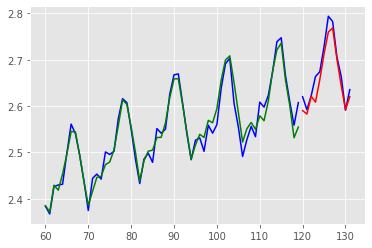

In [32]:
#   График с результатами

x2 = np.arange(60, 120, 1)
x3 = np.arange(120, 132, 1)

plt.plot(x2, y_train, color='blue')
plt.plot(x2, predictions_train, color='green')

plt.plot(x3, y_test, color='blue')
plt.plot(x3, predictions, color='red')

In [33]:
x = np.roll((X_test[-1]).copy(), -1)
print(x)
print()

x[-1] = y_test[-1]

print(x)

[2.62013605 2.59217676 2.62221402 2.66370093 2.673942   2.72835378
 2.79379038 2.78247262 2.70586371 2.66370093 2.59106461 2.60745502]

[2.62013605 2.59217676 2.62221402 2.66370093 2.673942   2.72835378
 2.79379038 2.78247262 2.70586371 2.66370093 2.59106461 2.63548375]


In [34]:
# создаем массив с месяцами для предсказания

def create_in_val():
    x = np.roll((X_test[-1]).copy(), -1)
    x[-1] = y_test[-1]
    return x

def predict (n):
    x = create_in_val()    
    predictions = np.zeros((n,1))    
    
    for i in range(0, n):
        p = model.predict(np.array([x]))
        predictions[i] = p
        
        for j in range(0, 11):
            x[j] = x[j + 1]
        x[11] = p
    
    return predictions

Для того, что бы получить предсказания на будущий год необходимо сделать 24 предсказания, т.к. данные за последний год ушли на тестовую выборку 

In [35]:
# n - количество предсказаний, которые будут сделаны с помощью модели
n = 24
predictions_future = predict(n)

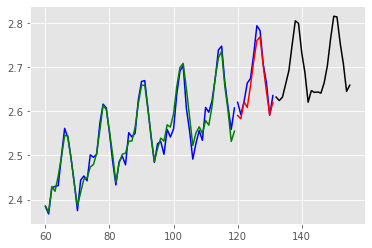

In [36]:
x2 = np.arange(60, 120, 1)
x3 = np.arange(120, 132, 1)
x4 = np.arange(132, 132+n, 1)

plt.plot(x2, y_train, color='blue')
plt.plot(x2, predictions_train, color='green')

plt.plot(x3, y_test, color='blue')
plt.plot(x3, predictions, color='red')
plt.plot(x4, predictions_future, color='black')

In [37]:
#смотрим на предсказанные на будущее значения (логарифмический масштаб)
predictions_future[n-12:]

array([[2.64258289],
       [2.64364672],
       [2.64103651],
       [2.66425228],
       [2.70283461],
       [2.7635603 ],
       [2.81519198],
       [2.81371903],
       [2.75462842],
       [2.70732951],
       [2.64507771],
       [2.65905094]])

In [38]:
#переводим из логарифмического масштаба
predictions_future_2 = 10**predictions_future.copy()

Text(0, 0.5, 'Тысяч человек')

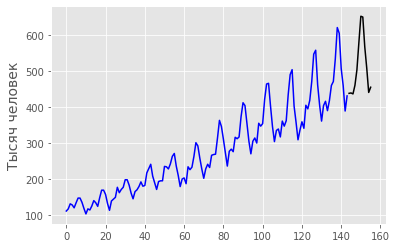

In [39]:
x1 = np.arange(0, 144, 1)
x2 = np.arange(144, 144+12, 1)

plt.plot(x1, ser_g['series_g'], color='blue')
plt.plot(x2, predictions_future_2[n-12:], color='black')
plt.ylabel('Тысяч человек', fontsize=14)

Выведем предсказанные значения на 12 месяцев вперед (тыс.чел. в месяц):

In [40]:
predictions_future_2[n-12:]

array([[439.11967199],
       [440.19663371],
       [437.55888851],
       [461.58563128],
       [504.46914229],
       [580.17671554],
       [653.4193393 ],
       [651.20696092],
       [568.36643136],
       [509.71746159],
       [441.64946164],
       [456.09041088]])